# Detection of Toxic Comments Using ML

Online store "Wikishop" launches a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, clients propose their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and submit them for moderation.  


The purpose of this work is to build a machine learning iomodel that will detect toxic comments. We have marked data with the text of comments and the target attribute toxic. It is necessary to build a model with the F1 metric value not less than 0.75.

## Preparation

In [1]:
# Importing required libraries and modules
import re
import string
import warnings
import sys

import nltk 
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from tqdm.notebook import tqdm
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14, 8)}, palette='Set2', font_scale=1.25)
tqdm.pandas()

In [ ]:
nltk.download('stopwords')  
!{sys.executable} -m spacy download en

In [2]:
# Data loading
data = pd.read_csv('toxic_comments.csv', index_col=0)

Displaying information about the dataset

In [3]:
data.sample(5)

,text,toxic
67257,profit organization. You BABY.,0
12006,"""\n\nWhen did I say I find anything offensive....",0
112265,"Chaz Ramirez\nChaz Ramirez died 15 years ago, ...",0
86860,Thanks. It's the building which is attractive....,0
87683,""" \n\nA great comment to be used in determinin...",0


In [4]:
data.shape

(159292, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

The table contains 159292 rows with data in 3 columns. There are no gaps in the data.

Ratio of classes in the 'toxic' column

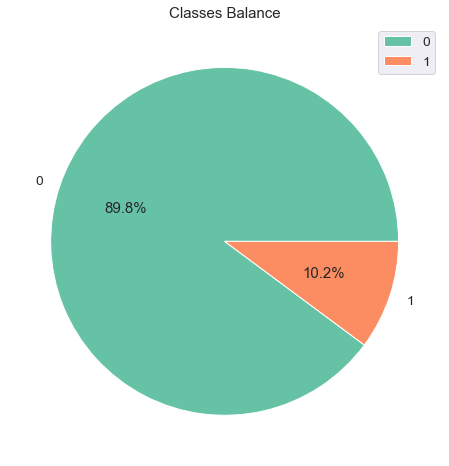

In [7]:
ax = data['toxic'].value_counts().plot(kind="pie", 
                                       autopct='%1.1f%%', 
                                       ylabel='', 
                                       legend=True, 
                                       title='Classes Balance', 
                                       figsize=(8, 8));

The class ratio is approximately 1:9.

### Feature generation

1. Clear the text of messages from unnecessary characters and metacharacters.
2. Bring the letters to a single case. 
3. Lemmatization
4. Lemmatized text can be translated into TF-IDF vectors. 
5. Next, we will supplement the signs with information that could be lost at the stage of text cleaning - letter case, punctuation, etc.

In [8]:
def cleaning(text):
    text = re.sub(r'[^\w\s]','', text).lower().strip()
    text = re.split('\W+', text)
    return text

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [10]:
def lemmatizer(text):
    text = ' '.join(text)
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [11]:
data['cleaned'] = data['text'].progress_apply(cleaning)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
data['lemmatized'] = data['cleaned'].progress_apply(lemmatizer)

  0%|          | 0/159292 [00:00<?, ?it/s]

The text has been cleaned up and lemmatized. We will translate into vector form after dividing into training and test samples.

In [13]:
data.sample(10)

,text,toxic,cleaned,lemmatized
63013,"Sure, if you gain consensus to do so. I believ...",0,"[sure, if, you, gain, consensus, to, do, so, i...",sure if you gain consensus to do so I believe ...
87539,This is the armeniapedia version about the bat...,0,"[this, is, the, armeniapedia, version, about, ...",this be the armeniapedia version about the bat...
74272,"oh... please accept my apology, i thought you ...",0,"[oh, please, accept, my, apology, i, thought, ...",oh please accept my apology I think you be som...
55742,Thanks! \n\nThanks for the revert on my user p...,0,"[thanks, thanks, for, the, revert, on, my, use...",thank thank for the revert on my user page
133907,"""\n\n ok \n\nOk i will leave it alone, but jus...",0,"[ok, ok, i, will, leave, it, alone, but, just,...",ok ok I will leave it alone but just leave the...
93479,"By contrast, clicking over to Naimark's dilati...",0,"[by, contrast, clicking, over, to, naimarks, d...",by contrast click over to naimark dilation the...
101159,"MSU Interview \n\nDear Jimfbleak,\n\nMy name i...",0,"[msu, interview, dear, jimfbleak, my, name, is...",msu interview dear jimfbleak my name be jonath...
42025,"deletion of WP:LEGAL \n\nHi, if you are going ...",0,"[deletion, of, wplegal, hi, if, you, are, goin...",deletion of wplegal hi if you be go to delete ...
75268,March 2007 \n Please stop. If you continue to ...,0,"[march, 2007, please, stop, if, you, continue,...",march 2007 please stop if you continue to vand...
8257,"""\nI could go with that. I think if we could f...",0,"[i, could, go, with, that, i, think, if, we, c...",I could go with that I think if we could find ...


#### Visualization of the most frequent words

In [14]:
def word_cloud_plot(class_number):
    text = ' '.join(data[data['toxic'] == class_number]['lemmatized'])
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Most frequent words from non-toxic comments

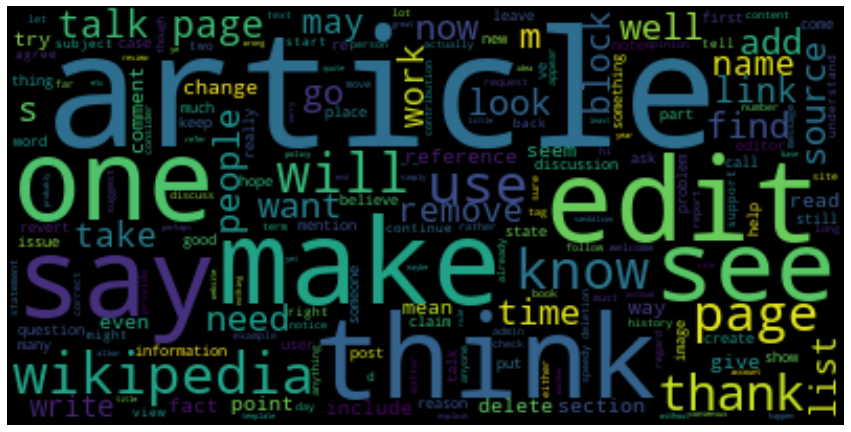

In [15]:
word_cloud_plot(0)

Most frequent words from toxic comments

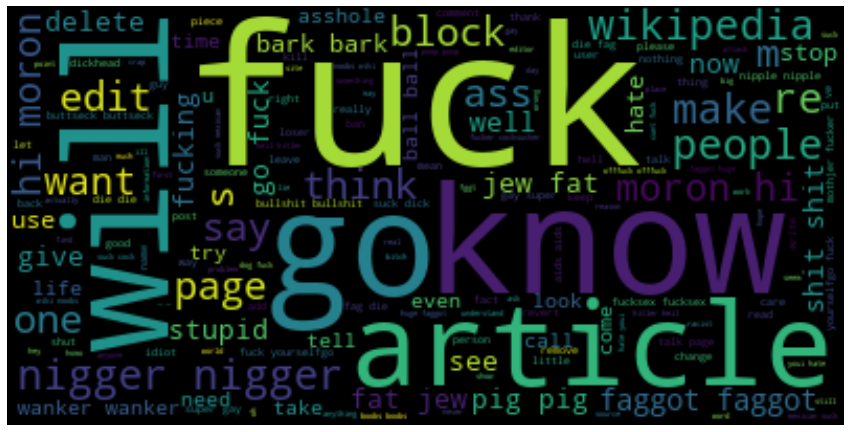

In [16]:
word_cloud_plot(1)

#### Ratio of the number of capital letters to the length of the word

The ratio of uppercase characters to the length of the string. There is a hypothesis that capital letters (capslock) are more common in toxic messages. Let's create such a sign and look at the distributions.

In [17]:
def upper_share(text):
    count = 0
    for char in text:
        if char.isupper():
            count += 1
    return count / len(text)

In [18]:
data['upper'] = data['text'].apply(upper_share)

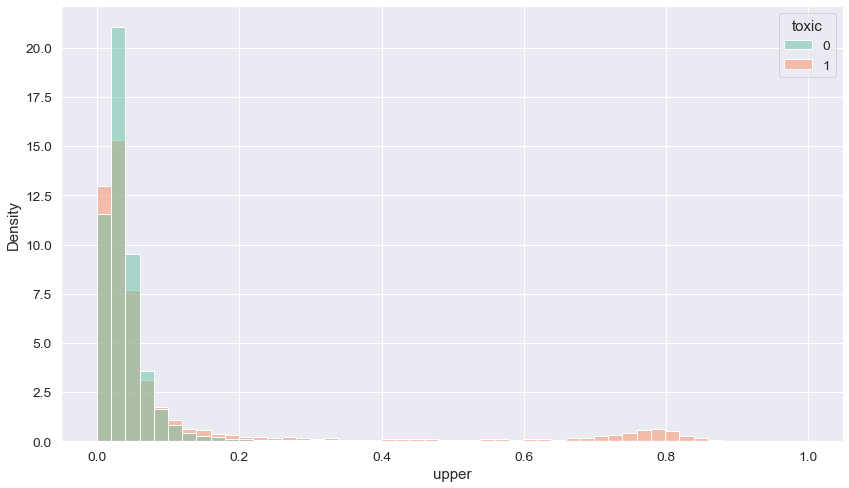

In [19]:
sns.histplot(data, 
             x='upper', 
             hue='toxic', 
             bins=50, 
             stat='density', 
             common_norm=False);

It is clearly noticeable that in the case of a large proportion of capital letters in the message (0.7-0.85), messages marked as toxic prevail.

#### The ratio of the number of capital letters at the beginning of a word to the number of words in the message.

Let's try to look at the ratio of words with a capital letter at the beginning of a word.

In [20]:
def capital_share(text):
    text = re.sub(r'[^\w\s]','', text).strip()
    text = re.split('\W+', text)
    count = 0
    for word in text:
        try:
            if word[0].isupper():
                count += 1
        except:
            pass
    if len(text) > 0:
        return count/len(text)
    else:
        return 0

In [21]:
data['capital'] = data['text'].apply(capital_share)

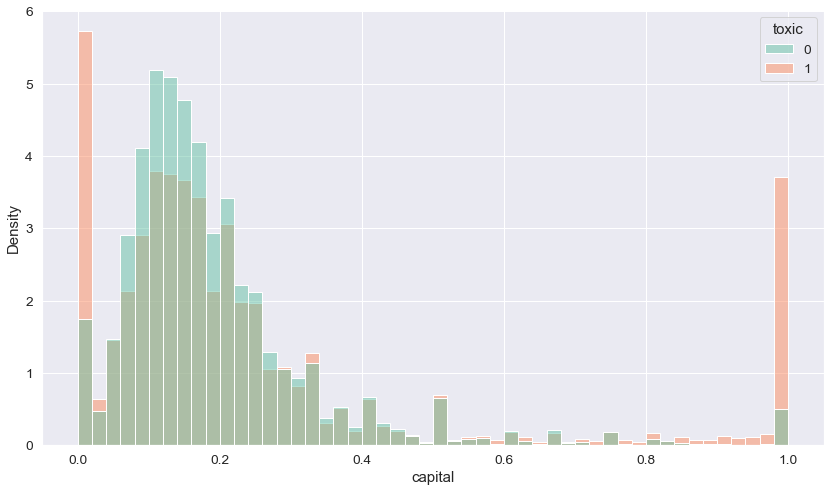

In [22]:
sns.histplot(data, 
             x='capital', 
             hue='toxic', 
             bins=50, 
             stat='density', 
             common_norm=False);

It is curious that messages with only capital letters in all words, and vice versa, without capital letters at the beginning of the word, are in most cases marked as toxic.

#### The ratio of the number of punctuation marks to the length of the message

In [23]:
def punct_share(text):
    count = 0
    for char in text:
        if char in string.punctuation:
            count += 1
    return count / len(text)

In [24]:
data['punct'] = data['text'].apply(punct_share)

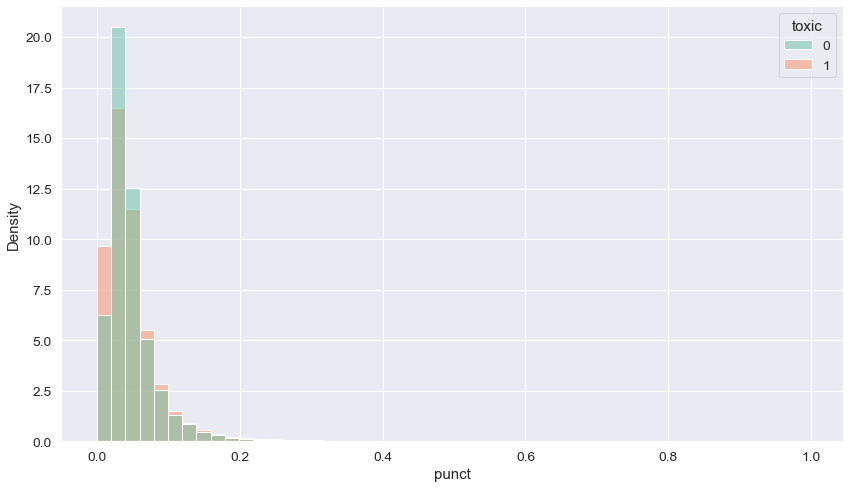

In [25]:
sns.histplot(data, 
             x='punct', 
             hue='toxic', 
             bins=50, 
             stat='density', 
             common_norm=False);

Looking at the graph, one cannot exclude such a pattern. One can see some division of classes on this basis.

#### Sentiment Analysis

Let's use the SentimentIntensityAnalyzer module to analyze the sentiment of messages to create 4 new features corresponding to the relative values of each of the tonality: positive, negative, neutral and complex.

In [26]:
def generate_sentiment_scores(data):
    SID = SentimentIntensityAnalyzer()
    Negative_Sentiment=[]
    Positive_Sentiment=[]
    Neutral_Sentiment=[]
    Compound_Sentiment=[]
    for sentence in (data.values): 
        sentence_sentiment_score = SID.polarity_scores(sentence)
        Compound_Sentiment.append(sentence_sentiment_score['compound'])
        Negative_Sentiment.append(sentence_sentiment_score['neg'])
        Positive_Sentiment.append(sentence_sentiment_score['pos'])
        Neutral_Sentiment.append(sentence_sentiment_score['neu'])
    return Compound_Sentiment, Negative_Sentiment, Positive_Sentiment, Neutral_Sentiment

In [27]:
data['compound_sentiment'], data['negative_sentiment'], data['positive_sentiment'],\
data['neutral_sentiment'] = generate_sentiment_scores(data['text'])

Distribution of feature values by classes

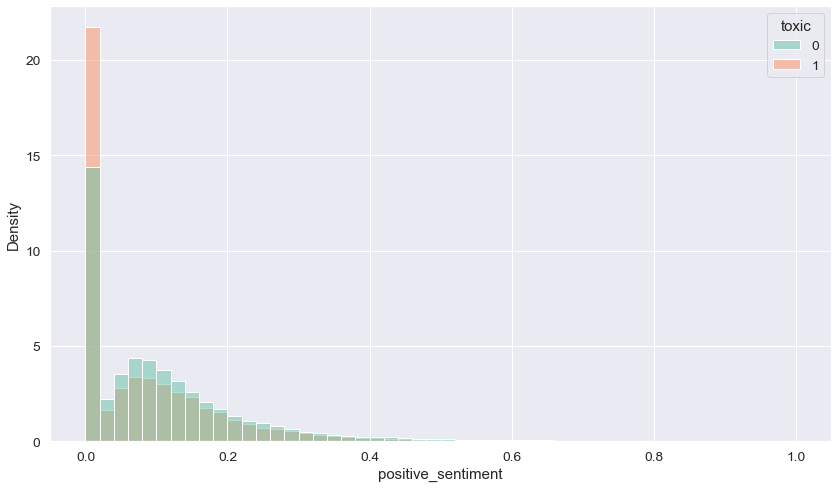

In [28]:
sns.histplot(data, 
             x='positive_sentiment', 
             hue='toxic', 
             bins=50, 
             stat='density', 
             common_norm=False);

Slight separation can be seen.

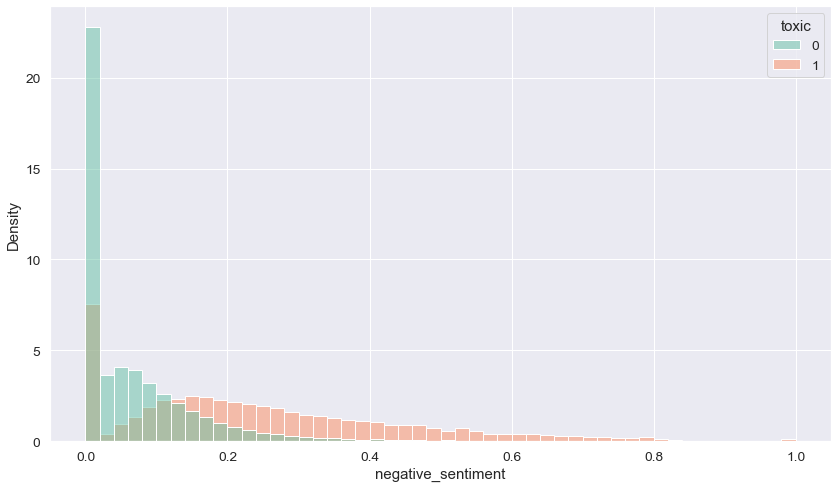

In [29]:
sns.histplot(data, 
             x='negative_sentiment', 
             hue='toxic', 
             bins=50, 
             stat='density', 
             common_norm=False);

Here the separation is more clear. Toxic messages tend to have a stronger negative tone.

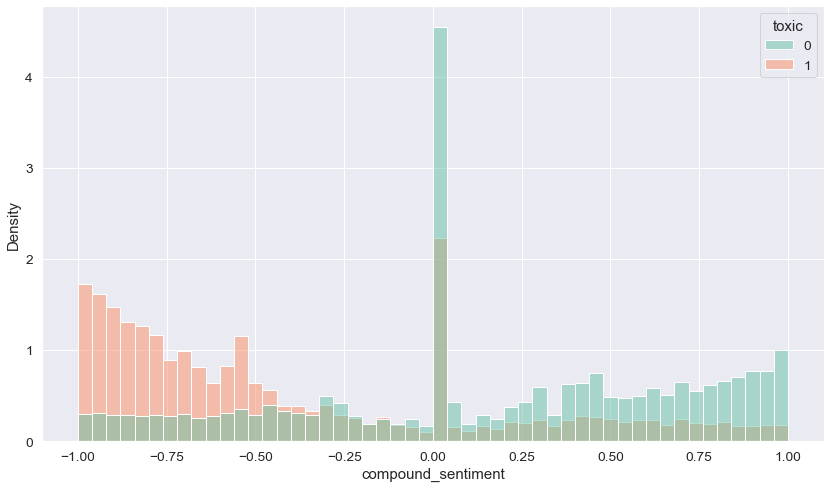

In [30]:
sns.histplot(data, 
             x='compound_sentiment', 
             hue='toxic', 
             bins=50, 
             stat='density', 
             common_norm=False);

There is also a significant separation.

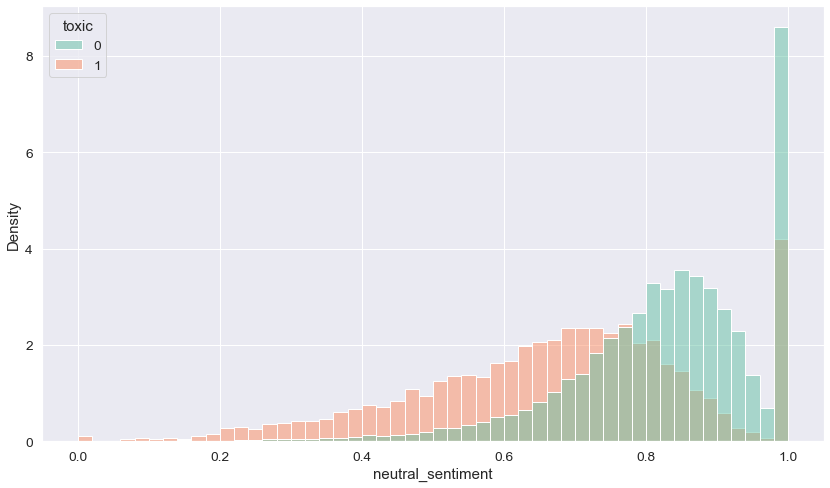

In [31]:
sns.histplot(data, 
             x='neutral_sentiment', 
             hue='toxic', 
             bins=50, 
             stat='density', 
             common_norm=False);

Non-toxic messages tend to be more neutral.

#### Removing unnecessary columns

In [32]:
data.drop(['cleaned'], inplace=True, axis=1)

###  Splitting into training and test sets

Splitting the samples in the ratio of 80 to 20.

In [33]:
train, test = train_test_split(data, 
                               test_size=0.20, 
                               stratify=data['toxic'], 
                               random_state=23)

In [34]:
# Features and target extraction
X_train = train.drop(['toxic', 'text'], axis=1)
y_train = train['toxic']
X_test = test.drop(['toxic', 'text'], axis=1)
y_test = test['toxic']

In [35]:
# Split for catboost classifier
X_train_cat = train.drop('toxic', axis=1)
X_test_cat = test.drop('toxic', axis=1)

In [36]:
# Preparing data for the catboost model by marking text features
train_pool = Pool(
    data=X_train_cat,
    label=y_train,
    text_features=['text', 'lemmatized']
)
test_pool = Pool(
    data=X_test_cat, 
    label=y_test,
    text_features=['text', 'lemmatized']
)

### Conclusion

The data contains 159292 lines of text messages. The ratio of classes in the data is approximately 1:9. No data missings or duplicates found. The following actions were carried out with features:
  - Texts have been cleaned up and lemmatized.
  - Sentiment analysis of the comments. Based on it, four features were created:
    - Positive tonality
    - Negative tone
    - Neutral tone
    - Complex tone
  - Additional features have also been created:
    - The ratio of the number of punctuation marks to the length of the text
    - The ratio of the number of capital letters to the length of the text
    - The ratio of the number of words with capital letters at the beginning of the word to the total number of words in the text.

## Models Training

In [37]:
# Stop-words list
stopwords = nltk.corpus.stopwords.words('english')

In [38]:
def model_learning_cv(estimator, features, target, params):
    """
    Function for training models with cross-validation
    """
    # Transforming test columns into TF-IDF vectors, and standardize numeric
    ct = ColumnTransformer(
                        [("text_preprocess", TfidfVectorizer(stop_words=stopwords), "lemmatized"),
                         ("num_preprocess", StandardScaler(), ['upper', 
                                                               'capital', 
                                                               'punct', 
                                                               'compound_sentiment', 
                                                               'negative_sentiment',
                                                               'positive_sentiment', 
                                                               'neutral_sentiment'])
                        ])

    
    pipe = Pipeline([('ftr_trans', ct),
                     ('est', estimator)
                    ])
    
    
    rs = RandomizedSearchCV(pipe, 
                            param_distributions=params, 
                            cv=5, random_state=23, 
                            n_iter=10, 
                            scoring='f1')
    
    rs.fit(features, target)
    
    
    return rs.best_score_, rs.best_estimator_, rs.best_params_

### Logistic Regression

In [39]:
params_lr = {'est__C': (50, 100, 200, 300)}

In [40]:
lr_score, lr_model, lr_params = model_learning_cv(LogisticRegression(class_weight='auto'), 
                                                  X_train, 
                                                  y_train, 
                                                  params_lr)

F1 score:

In [41]:
lr_score

0.7863620903819408

Best parameters

In [42]:
lr_params

{'est__C': 100}

### SVC Model

In [43]:
params_svc = {'est__C': (0.01, 0.1, 1, 10, 100)}

In [44]:
svc_score, svc_model, svc_params = model_learning_cv(LinearSVC(), 
                                                     X_train, 
                                                     y_train, 
                                                     params_svc)

F1 Score

In [45]:
svc_score

0.7851049094398663

Best parameters

In [46]:
svc_params

{'est__C': 1}

### Gradient Boosting Model (LightGBM)

LightGBM Gradient Boosting Model with Text Features Vectorization

In [47]:
params_lgbm = {'est__max_depth': list(range(1, 20, 2)),
               'est__learning_rate': np.arange(0.05, 1, 0.05),
               'est__n_estimators': [100, 200, 300]}

In [48]:
lgbm_score, lgbm_model, lgbm_params = model_learning_cv(
    LGBMClassifier(class_weight='balanced'), 
    X_train, 
    y_train, 
    params_lgbm)

F1 Score

In [49]:
lgbm_score

0.7525955428714335

Best parameters

In [50]:
lgbm_params

{'est__n_estimators': 300, 'est__max_depth': 9, 'est__learning_rate': 0.45}

### Gradient Boosting Model (Catboost) with built-in processing of text features

Gradient boosting model with built-in processing of text features.

In [51]:
model_cb = CatBoostClassifier(task_type='GPU',
                              eval_metric='F1',
                              od_type='Iter',
                              od_wait=500)

params_cb = {'learning_rate': [0.03, 0.05, 0.9],
             'depth': [4, 6, 10],
             'l2_leaf_reg': [1, 3, 5, 7]}

randomized_search_result = model_cb.randomized_search(params_cb,
                                                      train_pool,
                                                      plot=True,
                                                      refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3495689	test: 0.3371445	best: 0.3371445 (0)	total: 32.5ms	remaining: 32.5s
1:	learn: 0.4187101	test: 0.4146148	best: 0.4146148 (1)	total: 61.4ms	remaining: 30.6s
2:	learn: 0.3969510	test: 0.3906381	best: 0.4146148 (1)	total: 89.9ms	remaining: 29.9s
3:	learn: 0.4295838	test: 0.4322903	best: 0.4322903 (3)	total: 118ms	remaining: 29.5s
4:	learn: 0.4357542	test: 0.4370099	best: 0.4370099 (4)	total: 147ms	remaining: 29.2s
5:	learn: 0.4440550	test: 0.4449032	best: 0.4449032 (5)	total: 175ms	remaining: 29s
6:	learn: 0.4364207	test: 0.4321767	best: 0.4449032 (5)	total: 203ms	remaining: 28.8s
7:	learn: 0.4381678	test: 0.4374673	best: 0.4449032 (5)	total: 232ms	remaining: 28.7s
8:	learn: 0.4255408	test: 0.4202085	best: 0.4449032 (5)	total: 260ms	remaining: 28.6s
9:	learn: 0.4335962	test: 0.4297390	best: 0.4449032 (5)	total: 288ms	remaining: 28.5s
10:	learn: 0.4399728	test: 0.4350327	best: 0.4449032 (5)	total: 312ms	remaining: 28.1s
11:	learn: 0.4432564	test: 0.4370757	best: 0.4449032

102:	learn: 0.4766491	test: 0.4558824	best: 0.4629304 (90)	total: 2.42s	remaining: 21s
103:	learn: 0.4766491	test: 0.4557668	best: 0.4629304 (90)	total: 2.43s	remaining: 21s
104:	learn: 0.4776868	test: 0.4594320	best: 0.4629304 (90)	total: 2.46s	remaining: 20.9s
105:	learn: 0.4768509	test: 0.4594320	best: 0.4629304 (90)	total: 2.48s	remaining: 20.9s
106:	learn: 0.4771272	test: 0.4600558	best: 0.4629304 (90)	total: 2.5s	remaining: 20.9s
107:	learn: 0.4784329	test: 0.4613826	best: 0.4629304 (90)	total: 2.52s	remaining: 20.8s
108:	learn: 0.4792037	test: 0.4613826	best: 0.4629304 (90)	total: 2.55s	remaining: 20.8s
109:	learn: 0.4793726	test: 0.4607992	best: 0.4629304 (90)	total: 2.57s	remaining: 20.8s
110:	learn: 0.4802264	test: 0.4608388	best: 0.4629304 (90)	total: 2.59s	remaining: 20.8s
111:	learn: 0.4798578	test: 0.4604498	best: 0.4629304 (90)	total: 2.61s	remaining: 20.7s
112:	learn: 0.4801106	test: 0.4609553	best: 0.4629304 (90)	total: 2.63s	remaining: 20.7s
113:	learn: 0.4800369	test

199:	learn: 0.4866785	test: 0.4611895	best: 0.4651629 (140)	total: 4.51s	remaining: 18s
200:	learn: 0.4865789	test: 0.4611895	best: 0.4651629 (140)	total: 4.53s	remaining: 18s
201:	learn: 0.4866145	test: 0.4614610	best: 0.4651629 (140)	total: 4.55s	remaining: 18s
202:	learn: 0.4869840	test: 0.4605694	best: 0.4651629 (140)	total: 4.58s	remaining: 18s
203:	learn: 0.4869199	test: 0.4609572	best: 0.4651629 (140)	total: 4.6s	remaining: 17.9s
204:	learn: 0.4874778	test: 0.4625063	best: 0.4651629 (140)	total: 4.62s	remaining: 17.9s
205:	learn: 0.4877504	test: 0.4626227	best: 0.4651629 (140)	total: 4.64s	remaining: 17.9s
206:	learn: 0.4872402	test: 0.4605296	best: 0.4651629 (140)	total: 4.67s	remaining: 17.9s
207:	learn: 0.4883492	test: 0.4639798	best: 0.4651629 (140)	total: 4.69s	remaining: 17.9s
208:	learn: 0.4884363	test: 0.4635928	best: 0.4651629 (140)	total: 4.71s	remaining: 17.8s
209:	learn: 0.4881735	test: 0.4635928	best: 0.4651629 (140)	total: 4.73s	remaining: 17.8s
210:	learn: 0.48817

298:	learn: 0.4944789	test: 0.4639640	best: 0.4657671 (281)	total: 6.63s	remaining: 15.5s
299:	learn: 0.4945787	test: 0.4638479	best: 0.4657671 (281)	total: 6.65s	remaining: 15.5s
300:	learn: 0.4946770	test: 0.4638479	best: 0.4657671 (281)	total: 6.67s	remaining: 15.5s
301:	learn: 0.4946770	test: 0.4638479	best: 0.4657671 (281)	total: 6.69s	remaining: 15.5s
302:	learn: 0.4950055	test: 0.4641160	best: 0.4657671 (281)	total: 6.71s	remaining: 15.4s
303:	learn: 0.4945745	test: 0.4652326	best: 0.4657671 (281)	total: 6.74s	remaining: 15.4s
304:	learn: 0.4944775	test: 0.4651163	best: 0.4657671 (281)	total: 6.76s	remaining: 15.4s
305:	learn: 0.4949693	test: 0.4647324	best: 0.4657671 (281)	total: 6.78s	remaining: 15.4s
306:	learn: 0.4949693	test: 0.4648486	best: 0.4657671 (281)	total: 6.8s	remaining: 15.4s
307:	learn: 0.4946461	test: 0.4656508	best: 0.4657671 (281)	total: 6.83s	remaining: 15.3s
308:	learn: 0.4954967	test: 0.4653837	best: 0.4657671 (281)	total: 6.85s	remaining: 15.3s
309:	learn:

395:	learn: 0.5002930	test: 0.4641877	best: 0.4659855 (387)	total: 8.74s	remaining: 13.3s
396:	learn: 0.5012026	test: 0.4655215	best: 0.4659855 (387)	total: 8.76s	remaining: 13.3s
397:	learn: 0.5011700	test: 0.4655215	best: 0.4659855 (387)	total: 8.78s	remaining: 13.3s
398:	learn: 0.5008454	test: 0.4651394	best: 0.4659855 (387)	total: 8.8s	remaining: 13.3s
399:	learn: 0.5016257	test: 0.4642234	best: 0.4659855 (387)	total: 8.83s	remaining: 13.2s
400:	learn: 0.5014634	test: 0.4642234	best: 0.4659855 (387)	total: 8.85s	remaining: 13.2s
401:	learn: 0.5012685	test: 0.4646062	best: 0.4659855 (387)	total: 8.87s	remaining: 13.2s
402:	learn: 0.5011710	test: 0.4646062	best: 0.4659855 (387)	total: 8.89s	remaining: 13.2s
403:	learn: 0.5015275	test: 0.4646062	best: 0.4659855 (387)	total: 8.91s	remaining: 13.1s
404:	learn: 0.5023413	test: 0.4641077	best: 0.4659855 (387)	total: 8.93s	remaining: 13.1s
405:	learn: 0.5022772	test: 0.4638404	best: 0.4659855 (387)	total: 8.95s	remaining: 13.1s
406:	learn:

493:	learn: 0.5048342	test: 0.4696517	best: 0.4696517 (493)	total: 10.8s	remaining: 11.1s
494:	learn: 0.5042857	test: 0.4695349	best: 0.4696517 (493)	total: 10.9s	remaining: 11.1s
495:	learn: 0.5041569	test: 0.4695349	best: 0.4696517 (493)	total: 10.9s	remaining: 11s
496:	learn: 0.5040925	test: 0.4695349	best: 0.4696517 (493)	total: 10.9s	remaining: 11s
497:	learn: 0.5045115	test: 0.4694182	best: 0.4696517 (493)	total: 10.9s	remaining: 11s
498:	learn: 0.5048342	test: 0.4702085	best: 0.4702085 (498)	total: 10.9s	remaining: 11s
499:	learn: 0.5048027	test: 0.4702085	best: 0.4702085 (498)	total: 11s	remaining: 11s
500:	learn: 0.5052509	test: 0.4700918	best: 0.4702085 (498)	total: 11s	remaining: 10.9s
501:	learn: 0.5048959	test: 0.4703548	best: 0.4703548 (501)	total: 11s	remaining: 10.9s
502:	learn: 0.5046693	test: 0.4698586	best: 0.4703548 (501)	total: 11s	remaining: 10.9s
503:	learn: 0.5043828	test: 0.4713471	best: 0.4713471 (503)	total: 11s	remaining: 10.9s
504:	learn: 0.5043185	test: 0.

591:	learn: 0.5109006	test: 0.4689518	best: 0.4713471 (503)	total: 12.9s	remaining: 8.91s
592:	learn: 0.5104004	test: 0.4688900	best: 0.4713471 (503)	total: 13s	remaining: 8.89s
593:	learn: 0.5103368	test: 0.4685088	best: 0.4713471 (503)	total: 13s	remaining: 8.87s
594:	learn: 0.5105304	test: 0.4687733	best: 0.4713471 (503)	total: 13s	remaining: 8.85s
595:	learn: 0.5103672	test: 0.4680428	best: 0.4713471 (503)	total: 13s	remaining: 8.83s
596:	learn: 0.5104004	test: 0.4680428	best: 0.4713471 (503)	total: 13s	remaining: 8.8s
597:	learn: 0.5112684	test: 0.4688044	best: 0.4713471 (503)	total: 13.1s	remaining: 8.78s
598:	learn: 0.5105581	test: 0.4688044	best: 0.4713471 (503)	total: 13.1s	remaining: 8.76s
599:	learn: 0.5107185	test: 0.4691849	best: 0.4713471 (503)	total: 13.1s	remaining: 8.73s
600:	learn: 0.5109423	test: 0.4686879	best: 0.4713471 (503)	total: 13.1s	remaining: 8.71s
601:	learn: 0.5110058	test: 0.4696819	best: 0.4713471 (503)	total: 13.1s	remaining: 8.69s
602:	learn: 0.5110058

691:	learn: 0.5125439	test: 0.4688044	best: 0.4713471 (503)	total: 15s	remaining: 6.69s
692:	learn: 0.5126105	test: 0.4689209	best: 0.4713471 (503)	total: 15.1s	remaining: 6.67s
693:	learn: 0.5131502	test: 0.4696819	best: 0.4713471 (503)	total: 15.1s	remaining: 6.65s
694:	learn: 0.5131502	test: 0.4696819	best: 0.4713471 (503)	total: 15.1s	remaining: 6.62s
695:	learn: 0.5129870	test: 0.4699155	best: 0.4713471 (503)	total: 15.1s	remaining: 6.6s
696:	learn: 0.5130802	test: 0.4701789	best: 0.4713471 (503)	total: 15.1s	remaining: 6.58s
697:	learn: 0.5129271	test: 0.4691849	best: 0.4713471 (503)	total: 15.2s	remaining: 6.56s
698:	learn: 0.5130237	test: 0.4695652	best: 0.4713471 (503)	total: 15.2s	remaining: 6.53s
699:	learn: 0.5131169	test: 0.4696819	best: 0.4713471 (503)	total: 15.2s	remaining: 6.51s
700:	learn: 0.5132766	test: 0.4696819	best: 0.4713471 (503)	total: 15.2s	remaining: 6.49s
701:	learn: 0.5131169	test: 0.4696819	best: 0.4713471 (503)	total: 15.2s	remaining: 6.47s
702:	learn: 0

792:	learn: 0.5149336	test: 0.4718432	best: 0.4723119 (784)	total: 17.1s	remaining: 4.47s
793:	learn: 0.5144377	test: 0.4708220	best: 0.4723119 (784)	total: 17.2s	remaining: 4.45s
794:	learn: 0.5145895	test: 0.4710846	best: 0.4723119 (784)	total: 17.2s	remaining: 4.43s
795:	learn: 0.5147937	test: 0.4704715	best: 0.4723119 (784)	total: 17.2s	remaining: 4.41s
796:	learn: 0.5148566	test: 0.4702085	best: 0.4723119 (784)	total: 17.2s	remaining: 4.39s
797:	learn: 0.5144006	test: 0.4709677	best: 0.4723119 (784)	total: 17.2s	remaining: 4.37s
798:	learn: 0.5144006	test: 0.4705882	best: 0.4723119 (784)	total: 17.3s	remaining: 4.34s
799:	learn: 0.5143673	test: 0.4705882	best: 0.4723119 (784)	total: 17.3s	remaining: 4.32s
800:	learn: 0.5148155	test: 0.4712302	best: 0.4723119 (784)	total: 17.3s	remaining: 4.3s
801:	learn: 0.5148155	test: 0.4713471	best: 0.4723119 (784)	total: 17.3s	remaining: 4.28s
802:	learn: 0.5145600	test: 0.4708509	best: 0.4723119 (784)	total: 17.3s	remaining: 4.25s
803:	learn:

886:	learn: 0.5167955	test: 0.4690683	best: 0.4728085 (805)	total: 19s	remaining: 2.42s
887:	learn: 0.5168583	test: 0.4694486	best: 0.4728085 (805)	total: 19s	remaining: 2.4s
888:	learn: 0.5171473	test: 0.4690683	best: 0.4728085 (805)	total: 19.1s	remaining: 2.38s
889:	learn: 0.5171473	test: 0.4690683	best: 0.4728085 (805)	total: 19.1s	remaining: 2.36s
890:	learn: 0.5171473	test: 0.4690683	best: 0.4728085 (805)	total: 19.1s	remaining: 2.34s
891:	learn: 0.5170174	test: 0.4690683	best: 0.4728085 (805)	total: 19.1s	remaining: 2.31s
892:	learn: 0.5167284	test: 0.4680745	best: 0.4728085 (805)	total: 19.1s	remaining: 2.29s
893:	learn: 0.5177632	test: 0.4694486	best: 0.4728085 (805)	total: 19.2s	remaining: 2.27s
894:	learn: 0.5177494	test: 0.4686879	best: 0.4728085 (805)	total: 19.2s	remaining: 2.25s
895:	learn: 0.5179081	test: 0.4688354	best: 0.4728085 (805)	total: 19.2s	remaining: 2.23s
896:	learn: 0.5179174	test: 0.4693624	best: 0.4728085 (805)	total: 19.2s	remaining: 2.21s
897:	learn: 0.5

980:	learn: 0.5198341	test: 0.4701511	best: 0.4728085 (805)	total: 20.9s	remaining: 405ms
981:	learn: 0.5200881	test: 0.4698885	best: 0.4728085 (805)	total: 20.9s	remaining: 384ms
982:	learn: 0.5191186	test: 0.4700050	best: 0.4728085 (805)	total: 21s	remaining: 363ms
983:	learn: 0.5178652	test: 0.4695394	best: 0.4728085 (805)	total: 21s	remaining: 341ms
984:	learn: 0.5184849	test: 0.4701511	best: 0.4728085 (805)	total: 21s	remaining: 320ms
985:	learn: 0.5184513	test: 0.4705300	best: 0.4728085 (805)	total: 21s	remaining: 299ms
986:	learn: 0.5184513	test: 0.4705300	best: 0.4728085 (805)	total: 21s	remaining: 277ms
987:	learn: 0.5184897	test: 0.4690134	best: 0.4728085 (805)	total: 21.1s	remaining: 256ms
988:	learn: 0.5182349	test: 0.4686338	best: 0.4728085 (805)	total: 21.1s	remaining: 235ms
989:	learn: 0.5181435	test: 0.4682540	best: 0.4728085 (805)	total: 21.1s	remaining: 213ms
990:	learn: 0.5182396	test: 0.4682540	best: 0.4728085 (805)	total: 21.1s	remaining: 192ms
991:	learn: 0.518494

81:	learn: 0.4171033	test: 0.4198984	best: 0.4264591 (0)	total: 1.89s	remaining: 21.1s
82:	learn: 0.4174290	test: 0.4202085	best: 0.4264591 (0)	total: 1.91s	remaining: 21.1s
83:	learn: 0.4177896	test: 0.4197597	best: 0.4264591 (0)	total: 1.93s	remaining: 21.1s
84:	learn: 0.4181438	test: 0.4206031	best: 0.4264591 (0)	total: 1.95s	remaining: 21s
85:	learn: 0.4180334	test: 0.4202937	best: 0.4264591 (0)	total: 1.98s	remaining: 21s
86:	learn: 0.4181958	test: 0.4202937	best: 0.4264591 (0)	total: 2s	remaining: 21s
87:	learn: 0.4191817	test: 0.4207154	best: 0.4264591 (0)	total: 2.02s	remaining: 21s
88:	learn: 0.4194020	test: 0.4201815	best: 0.4264591 (0)	total: 2.05s	remaining: 21s
89:	learn: 0.4200557	test: 0.4200694	best: 0.4264591 (0)	total: 2.07s	remaining: 21s
90:	learn: 0.4208110	test: 0.4229028	best: 0.4264591 (0)	total: 2.1s	remaining: 20.9s
91:	learn: 0.4213307	test: 0.4233227	best: 0.4264591 (0)	total: 2.12s	remaining: 20.9s
92:	learn: 0.4212503	test: 0.4233227	best: 0.4264591 (0)	to

181:	learn: 0.4376242	test: 0.4381551	best: 0.4387300 (163)	total: 4.2s	remaining: 18.9s
182:	learn: 0.4373501	test: 0.4385643	best: 0.4387300 (163)	total: 4.22s	remaining: 18.8s
183:	learn: 0.4376883	test: 0.4385643	best: 0.4387300 (163)	total: 4.24s	remaining: 18.8s
184:	learn: 0.4380261	test: 0.4385643	best: 0.4387300 (163)	total: 4.27s	remaining: 18.8s
185:	learn: 0.4381930	test: 0.4385643	best: 0.4387300 (163)	total: 4.29s	remaining: 18.8s
186:	learn: 0.4381330	test: 0.4388583	best: 0.4388583 (186)	total: 4.31s	remaining: 18.8s
187:	learn: 0.4381500	test: 0.4392670	best: 0.4392670 (187)	total: 4.34s	remaining: 18.7s
188:	learn: 0.4385173	test: 0.4395604	best: 0.4395604 (188)	total: 4.36s	remaining: 18.7s
189:	learn: 0.4386409	test: 0.4393820	best: 0.4395604 (188)	total: 4.38s	remaining: 18.7s
190:	learn: 0.4389610	test: 0.4396755	best: 0.4396755 (190)	total: 4.41s	remaining: 18.7s
191:	learn: 0.4389910	test: 0.4392670	best: 0.4396755 (190)	total: 4.43s	remaining: 18.6s
192:	learn:

274:	learn: 0.4472597	test: 0.4469303	best: 0.4477379 (267)	total: 6.32s	remaining: 16.7s
275:	learn: 0.4473506	test: 0.4473342	best: 0.4477379 (267)	total: 6.35s	remaining: 16.6s
276:	learn: 0.4475022	test: 0.4480249	best: 0.4480249 (276)	total: 6.37s	remaining: 16.6s
277:	learn: 0.4477288	test: 0.4479085	best: 0.4480249 (276)	total: 6.39s	remaining: 16.6s
278:	learn: 0.4476539	test: 0.4481414	best: 0.4481414 (278)	total: 6.41s	remaining: 16.6s
279:	learn: 0.4476843	test: 0.4480249	best: 0.4481414 (278)	total: 6.44s	remaining: 16.6s
280:	learn: 0.4475041	test: 0.4480249	best: 0.4481414 (278)	total: 6.46s	remaining: 16.5s
281:	learn: 0.4474595	test: 0.4481414	best: 0.4481414 (278)	total: 6.48s	remaining: 16.5s
282:	learn: 0.4474434	test: 0.4489478	best: 0.4489478 (282)	total: 6.5s	remaining: 16.5s
283:	learn: 0.4475790	test: 0.4488312	best: 0.4489478 (282)	total: 6.53s	remaining: 16.5s
284:	learn: 0.4475487	test: 0.4488312	best: 0.4489478 (282)	total: 6.55s	remaining: 16.4s
285:	learn:

374:	learn: 0.4531261	test: 0.4533195	best: 0.4537205 (368)	total: 8.65s	remaining: 14.4s
375:	learn: 0.4529296	test: 0.4538382	best: 0.4538382 (375)	total: 8.68s	remaining: 14.4s
376:	learn: 0.4529909	test: 0.4538382	best: 0.4538382 (375)	total: 8.7s	remaining: 14.4s
377:	learn: 0.4530215	test: 0.4538382	best: 0.4538382 (375)	total: 8.73s	remaining: 14.4s
378:	learn: 0.4530342	test: 0.4542390	best: 0.4542390 (378)	total: 8.75s	remaining: 14.3s
379:	learn: 0.4531261	test: 0.4542390	best: 0.4542390 (378)	total: 8.78s	remaining: 14.3s
380:	learn: 0.4532432	test: 0.4542390	best: 0.4542390 (378)	total: 8.8s	remaining: 14.3s
381:	learn: 0.4534397	test: 0.4542390	best: 0.4542390 (378)	total: 8.82s	remaining: 14.3s
382:	learn: 0.4534090	test: 0.4538382	best: 0.4542390 (378)	total: 8.85s	remaining: 14.3s
383:	learn: 0.4533351	test: 0.4542390	best: 0.4542390 (378)	total: 8.87s	remaining: 14.2s
384:	learn: 0.4532612	test: 0.4537205	best: 0.4542390 (378)	total: 8.89s	remaining: 14.2s
385:	learn: 

474:	learn: 0.4569657	test: 0.4526834	best: 0.4552046 (392)	total: 11s	remaining: 12.2s
475:	learn: 0.4569965	test: 0.4526834	best: 0.4552046 (392)	total: 11s	remaining: 12.1s
476:	learn: 0.4569349	test: 0.4526834	best: 0.4552046 (392)	total: 11.1s	remaining: 12.1s
477:	learn: 0.4569349	test: 0.4526834	best: 0.4552046 (392)	total: 11.1s	remaining: 12.1s
478:	learn: 0.4567885	test: 0.4528008	best: 0.4552046 (392)	total: 11.1s	remaining: 12.1s
479:	learn: 0.4569233	test: 0.4533195	best: 0.4552046 (392)	total: 11.1s	remaining: 12s
480:	learn: 0.4571313	test: 0.4537205	best: 0.4552046 (392)	total: 11.1s	remaining: 12s
481:	learn: 0.4570273	test: 0.4537205	best: 0.4552046 (392)	total: 11.2s	remaining: 12s
482:	learn: 0.4571313	test: 0.4537205	best: 0.4552046 (392)	total: 11.2s	remaining: 12s
483:	learn: 0.4573701	test: 0.4537205	best: 0.4552046 (392)	total: 11.2s	remaining: 12s
484:	learn: 0.4574432	test: 0.4537205	best: 0.4552046 (392)	total: 11.2s	remaining: 11.9s
485:	learn: 0.4574432	te

566:	learn: 0.4587205	test: 0.4532505	best: 0.4552046 (392)	total: 13.1s	remaining: 10s
567:	learn: 0.4587823	test: 0.4531331	best: 0.4552046 (392)	total: 13.2s	remaining: 10s
568:	learn: 0.4588132	test: 0.4530158	best: 0.4552046 (392)	total: 13.2s	remaining: 9.98s
569:	learn: 0.4587823	test: 0.4534161	best: 0.4552046 (392)	total: 13.2s	remaining: 9.96s
570:	learn: 0.4590517	test: 0.4538163	best: 0.4552046 (392)	total: 13.2s	remaining: 9.94s
571:	learn: 0.4589590	test: 0.4538163	best: 0.4552046 (392)	total: 13.2s	remaining: 9.91s
572:	learn: 0.4590628	test: 0.4534161	best: 0.4552046 (392)	total: 13.3s	remaining: 9.89s
573:	learn: 0.4589899	test: 0.4535335	best: 0.4552046 (392)	total: 13.3s	remaining: 9.87s
574:	learn: 0.4590318	test: 0.4536510	best: 0.4552046 (392)	total: 13.3s	remaining: 9.84s
575:	learn: 0.4589281	test: 0.4536510	best: 0.4552046 (392)	total: 13.3s	remaining: 9.82s
576:	learn: 0.4591775	test: 0.4535335	best: 0.4552046 (392)	total: 13.4s	remaining: 9.79s
577:	learn: 0.

658:	learn: 0.4615798	test: 0.4540988	best: 0.4552046 (392)	total: 15.3s	remaining: 7.91s
659:	learn: 0.4615488	test: 0.4544984	best: 0.4552046 (392)	total: 15.3s	remaining: 7.88s
660:	learn: 0.4616109	test: 0.4544984	best: 0.4552046 (392)	total: 15.3s	remaining: 7.86s
661:	learn: 0.4612385	test: 0.4544984	best: 0.4552046 (392)	total: 15.3s	remaining: 7.84s
662:	learn: 0.4611350	test: 0.4546160	best: 0.4552046 (392)	total: 15.4s	remaining: 7.81s
663:	learn: 0.4613730	test: 0.4543810	best: 0.4552046 (392)	total: 15.4s	remaining: 7.79s
664:	learn: 0.4613419	test: 0.4543810	best: 0.4552046 (392)	total: 15.4s	remaining: 7.77s
665:	learn: 0.4609280	test: 0.4542636	best: 0.4552046 (392)	total: 15.4s	remaining: 7.74s
666:	learn: 0.4610315	test: 0.4542636	best: 0.4552046 (392)	total: 15.5s	remaining: 7.72s
667:	learn: 0.4609280	test: 0.4542636	best: 0.4552046 (392)	total: 15.5s	remaining: 7.7s
668:	learn: 0.4608970	test: 0.4541462	best: 0.4552046 (392)	total: 15.5s	remaining: 7.67s
669:	learn:

751:	learn: 0.4623244	test: 0.4552258	best: 0.4555068 (728)	total: 17.4s	remaining: 5.74s
752:	learn: 0.4623656	test: 0.4551084	best: 0.4555068 (728)	total: 17.4s	remaining: 5.72s
753:	learn: 0.4625311	test: 0.4551084	best: 0.4555068 (728)	total: 17.5s	remaining: 5.7s
754:	learn: 0.4626344	test: 0.4553433	best: 0.4555068 (728)	total: 17.5s	remaining: 5.68s
755:	learn: 0.4625311	test: 0.4549445	best: 0.4555068 (728)	total: 17.5s	remaining: 5.65s
756:	learn: 0.4626033	test: 0.4549445	best: 0.4555068 (728)	total: 17.5s	remaining: 5.63s
757:	learn: 0.4625000	test: 0.4550620	best: 0.4555068 (728)	total: 17.6s	remaining: 5.61s
758:	learn: 0.4626344	test: 0.4549445	best: 0.4555068 (728)	total: 17.6s	remaining: 5.58s
759:	learn: 0.4627377	test: 0.4553433	best: 0.4555068 (728)	total: 17.6s	remaining: 5.56s
760:	learn: 0.4625622	test: 0.4552258	best: 0.4555068 (728)	total: 17.6s	remaining: 5.54s
761:	learn: 0.4625311	test: 0.4553433	best: 0.4555068 (728)	total: 17.7s	remaining: 5.51s
762:	learn:

850:	learn: 0.4638829	test: 0.4549445	best: 0.4556244 (775)	total: 19.7s	remaining: 3.45s
851:	learn: 0.4641611	test: 0.4553433	best: 0.4556244 (775)	total: 19.8s	remaining: 3.43s
852:	learn: 0.4642330	test: 0.4553433	best: 0.4556244 (775)	total: 19.8s	remaining: 3.41s
853:	learn: 0.4642330	test: 0.4553433	best: 0.4556244 (775)	total: 19.8s	remaining: 3.38s
854:	learn: 0.4641299	test: 0.4553433	best: 0.4556244 (775)	total: 19.8s	remaining: 3.36s
855:	learn: 0.4642330	test: 0.4554609	best: 0.4556244 (775)	total: 19.8s	remaining: 3.34s
856:	learn: 0.4644391	test: 0.4554609	best: 0.4556244 (775)	total: 19.9s	remaining: 3.31s
857:	learn: 0.4643360	test: 0.4554609	best: 0.4556244 (775)	total: 19.9s	remaining: 3.29s
858:	learn: 0.4643360	test: 0.4554609	best: 0.4556244 (775)	total: 19.9s	remaining: 3.27s
859:	learn: 0.4641299	test: 0.4555785	best: 0.4556244 (775)	total: 19.9s	remaining: 3.25s
860:	learn: 0.4639957	test: 0.4559773	best: 0.4559773 (860)	total: 20s	remaining: 3.22s
861:	learn: 

948:	learn: 0.4647481	test: 0.4560950	best: 0.4568921 (867)	total: 22.1s	remaining: 1.19s
949:	learn: 0.4648511	test: 0.4564937	best: 0.4568921 (867)	total: 22.1s	remaining: 1.16s
950:	learn: 0.4646763	test: 0.4564937	best: 0.4568921 (867)	total: 22.1s	remaining: 1.14s
951:	learn: 0.4646763	test: 0.4564937	best: 0.4568921 (867)	total: 22.1s	remaining: 1.12s
952:	learn: 0.4647793	test: 0.4563758	best: 0.4568921 (867)	total: 22.2s	remaining: 1.09s
953:	learn: 0.4647793	test: 0.4564937	best: 0.4568921 (867)	total: 22.2s	remaining: 1.07s
954:	learn: 0.4649135	test: 0.4564937	best: 0.4568921 (867)	total: 22.2s	remaining: 1.05s
955:	learn: 0.4648823	test: 0.4564937	best: 0.4568921 (867)	total: 22.2s	remaining: 1.02s
956:	learn: 0.4646763	test: 0.4564937	best: 0.4568921 (867)	total: 22.2s	remaining: 1000ms
957:	learn: 0.4648823	test: 0.4564937	best: 0.4568921 (867)	total: 22.3s	remaining: 976ms
958:	learn: 0.4648823	test: 0.4564937	best: 0.4568921 (867)	total: 22.3s	remaining: 953ms
959:	lear

42:	learn: 0.4087900	test: 0.4079978	best: 0.4264591 (0)	total: 1.01s	remaining: 22.5s
43:	learn: 0.4090717	test: 0.4088577	best: 0.4264591 (0)	total: 1.03s	remaining: 22.4s
44:	learn: 0.4095164	test: 0.4097166	best: 0.4264591 (0)	total: 1.05s	remaining: 22.4s
45:	learn: 0.4089628	test: 0.4089803	best: 0.4264591 (0)	total: 1.08s	remaining: 22.4s
46:	learn: 0.4088795	test: 0.4089803	best: 0.4264591 (0)	total: 1.1s	remaining: 22.4s
47:	learn: 0.4097183	test: 0.4086486	best: 0.4264591 (0)	total: 1.13s	remaining: 22.3s
48:	learn: 0.4105522	test: 0.4106854	best: 0.4264591 (0)	total: 1.15s	remaining: 22.3s
49:	learn: 0.4113924	test: 0.4114317	best: 0.4264591 (0)	total: 1.17s	remaining: 22.3s
50:	learn: 0.4113924	test: 0.4128267	best: 0.4264591 (0)	total: 1.2s	remaining: 22.3s
51:	learn: 0.4116655	test: 0.4128267	best: 0.4264591 (0)	total: 1.22s	remaining: 22.3s
52:	learn: 0.4120539	test: 0.4141088	best: 0.4264591 (0)	total: 1.25s	remaining: 22.3s
53:	learn: 0.4121246	test: 0.4113360	best: 0.

141:	learn: 0.4313725	test: 0.4364306	best: 0.4367756 (140)	total: 3.33s	remaining: 20.1s
142:	learn: 0.4315398	test: 0.4373024	best: 0.4373024 (142)	total: 3.35s	remaining: 20.1s
143:	learn: 0.4317259	test: 0.4373684	best: 0.4373684 (143)	total: 3.38s	remaining: 20.1s
144:	learn: 0.4322541	test: 0.4371383	best: 0.4373684 (143)	total: 3.4s	remaining: 20.1s
145:	learn: 0.4321947	test: 0.4370234	best: 0.4373684 (143)	total: 3.42s	remaining: 20s
146:	learn: 0.4320869	test: 0.4369085	best: 0.4373684 (143)	total: 3.44s	remaining: 20s
147:	learn: 0.4320869	test: 0.4366789	best: 0.4373684 (143)	total: 3.47s	remaining: 20s
148:	learn: 0.4320869	test: 0.4366789	best: 0.4373684 (143)	total: 3.49s	remaining: 19.9s
149:	learn: 0.4320759	test: 0.4362681	best: 0.4373684 (143)	total: 3.52s	remaining: 19.9s
150:	learn: 0.4329670	test: 0.4366789	best: 0.4373684 (143)	total: 3.54s	remaining: 19.9s
151:	learn: 0.4329373	test: 0.4372703	best: 0.4373684 (143)	total: 3.56s	remaining: 19.9s
152:	learn: 0.433

240:	learn: 0.4437050	test: 0.4439240	best: 0.4447334 (233)	total: 5.62s	remaining: 17.7s
241:	learn: 0.4434180	test: 0.4440396	best: 0.4447334 (233)	total: 5.64s	remaining: 17.7s
242:	learn: 0.4436146	test: 0.4441552	best: 0.4447334 (233)	total: 5.66s	remaining: 17.6s
243:	learn: 0.4439919	test: 0.4440396	best: 0.4447334 (233)	total: 5.69s	remaining: 17.6s
244:	learn: 0.4443841	test: 0.4444444	best: 0.4447334 (233)	total: 5.71s	remaining: 17.6s
245:	learn: 0.4444897	test: 0.4443288	best: 0.4447334 (233)	total: 5.73s	remaining: 17.6s
246:	learn: 0.4445651	test: 0.4443288	best: 0.4447334 (233)	total: 5.76s	remaining: 17.6s
247:	learn: 0.4447761	test: 0.4451378	best: 0.4451378 (247)	total: 5.78s	remaining: 17.5s
248:	learn: 0.4445801	test: 0.4451378	best: 0.4451378 (247)	total: 5.8s	remaining: 17.5s
249:	learn: 0.4443691	test: 0.4454262	best: 0.4454262 (249)	total: 5.83s	remaining: 17.5s
250:	learn: 0.4444143	test: 0.4447334	best: 0.4454262 (249)	total: 5.85s	remaining: 17.5s
251:	learn:

340:	learn: 0.4525242	test: 0.4541688	best: 0.4550155 (334)	total: 7.96s	remaining: 15.4s
341:	learn: 0.4524936	test: 0.4541688	best: 0.4550155 (334)	total: 7.98s	remaining: 15.4s
342:	learn: 0.4527639	test: 0.4545690	best: 0.4550155 (334)	total: 8.01s	remaining: 15.3s
343:	learn: 0.4527639	test: 0.4541688	best: 0.4550155 (334)	total: 8.03s	remaining: 15.3s
344:	learn: 0.4525676	test: 0.4544513	best: 0.4550155 (334)	total: 8.05s	remaining: 15.3s
345:	learn: 0.4520141	test: 0.4545690	best: 0.4550155 (334)	total: 8.07s	remaining: 15.3s
346:	learn: 0.4520881	test: 0.4544513	best: 0.4550155 (334)	total: 8.1s	remaining: 15.2s
347:	learn: 0.4520011	test: 0.4541688	best: 0.4550155 (334)	total: 8.12s	remaining: 15.2s
348:	learn: 0.4523279	test: 0.4549689	best: 0.4550155 (334)	total: 8.14s	remaining: 15.2s
349:	learn: 0.4524936	test: 0.4545690	best: 0.4550155 (334)	total: 8.17s	remaining: 15.2s
350:	learn: 0.4525981	test: 0.4544513	best: 0.4550155 (334)	total: 8.19s	remaining: 15.1s
351:	learn:

440:	learn: 0.4568309	test: 0.4536029	best: 0.4563585 (373)	total: 10.3s	remaining: 13s
441:	learn: 0.4566345	test: 0.4536029	best: 0.4563585 (373)	total: 10.3s	remaining: 13s
442:	learn: 0.4566961	test: 0.4537205	best: 0.4563585 (373)	total: 10.3s	remaining: 13s
443:	learn: 0.4567269	test: 0.4532020	best: 0.4563585 (373)	total: 10.4s	remaining: 13s
444:	learn: 0.4567269	test: 0.4536029	best: 0.4563585 (373)	total: 10.4s	remaining: 12.9s
445:	learn: 0.4568309	test: 0.4536029	best: 0.4563585 (373)	total: 10.4s	remaining: 12.9s
446:	learn: 0.4569657	test: 0.4540036	best: 0.4563585 (373)	total: 10.4s	remaining: 12.9s
447:	learn: 0.4569657	test: 0.4540036	best: 0.4563585 (373)	total: 10.4s	remaining: 12.9s
448:	learn: 0.4568617	test: 0.4540036	best: 0.4563585 (373)	total: 10.5s	remaining: 12.9s
449:	learn: 0.4571313	test: 0.4544041	best: 0.4563585 (373)	total: 10.5s	remaining: 12.8s
450:	learn: 0.4573393	test: 0.4544041	best: 0.4563585 (373)	total: 10.5s	remaining: 12.8s
451:	learn: 0.4573

537:	learn: 0.4579515	test: 0.4538382	best: 0.4563585 (373)	total: 12.6s	remaining: 10.8s
538:	learn: 0.4578476	test: 0.4542390	best: 0.4563585 (373)	total: 12.6s	remaining: 10.8s
539:	learn: 0.4579515	test: 0.4542390	best: 0.4563585 (373)	total: 12.7s	remaining: 10.8s
540:	learn: 0.4579206	test: 0.4542390	best: 0.4563585 (373)	total: 12.7s	remaining: 10.8s
541:	learn: 0.4577550	test: 0.4542390	best: 0.4563585 (373)	total: 12.7s	remaining: 10.7s
542:	learn: 0.4578281	test: 0.4542390	best: 0.4563585 (373)	total: 12.7s	remaining: 10.7s
543:	learn: 0.4578898	test: 0.4542390	best: 0.4563585 (373)	total: 12.8s	remaining: 10.7s
544:	learn: 0.4578476	test: 0.4546397	best: 0.4563585 (373)	total: 12.8s	remaining: 10.7s
545:	learn: 0.4583670	test: 0.4546397	best: 0.4563585 (373)	total: 12.8s	remaining: 10.7s
546:	learn: 0.4582014	test: 0.4546397	best: 0.4563585 (373)	total: 12.9s	remaining: 10.6s
547:	learn: 0.4582632	test: 0.4546397	best: 0.4563585 (373)	total: 12.9s	remaining: 10.6s
548:	learn

632:	learn: 0.4596014	test: 0.4554404	best: 0.4563585 (373)	total: 15s	remaining: 8.71s
633:	learn: 0.4597252	test: 0.4550402	best: 0.4563585 (373)	total: 15s	remaining: 8.69s
634:	learn: 0.4596633	test: 0.4550402	best: 0.4563585 (373)	total: 15.1s	remaining: 8.66s
635:	learn: 0.4596323	test: 0.4554404	best: 0.4563585 (373)	total: 15.1s	remaining: 8.64s
636:	learn: 0.4597980	test: 0.4554404	best: 0.4563585 (373)	total: 15.1s	remaining: 8.62s
637:	learn: 0.4598289	test: 0.4554404	best: 0.4563585 (373)	total: 15.1s	remaining: 8.59s
638:	learn: 0.4598289	test: 0.4554404	best: 0.4563585 (373)	total: 15.2s	remaining: 8.57s
639:	learn: 0.4599327	test: 0.4554404	best: 0.4563585 (373)	total: 15.2s	remaining: 8.55s
640:	learn: 0.4600471	test: 0.4554404	best: 0.4563585 (373)	total: 15.2s	remaining: 8.52s
641:	learn: 0.4600888	test: 0.4553225	best: 0.4563585 (373)	total: 15.2s	remaining: 8.5s
642:	learn: 0.4601198	test: 0.4553225	best: 0.4563585 (373)	total: 15.3s	remaining: 8.48s
643:	learn: 0.4

730:	learn: 0.4621900	test: 0.4540513	best: 0.4563585 (373)	total: 17.4s	remaining: 6.42s
731:	learn: 0.4621176	test: 0.4540513	best: 0.4563585 (373)	total: 17.5s	remaining: 6.4s
732:	learn: 0.4621176	test: 0.4540513	best: 0.4563585 (373)	total: 17.5s	remaining: 6.38s
733:	learn: 0.4622210	test: 0.4544513	best: 0.4563585 (373)	total: 17.5s	remaining: 6.35s
734:	learn: 0.4623555	test: 0.4544513	best: 0.4563585 (373)	total: 17.6s	remaining: 6.33s
735:	learn: 0.4624588	test: 0.4544513	best: 0.4563585 (373)	total: 17.6s	remaining: 6.3s
736:	learn: 0.4625311	test: 0.4544513	best: 0.4563585 (373)	total: 17.6s	remaining: 6.28s
737:	learn: 0.4624277	test: 0.4544513	best: 0.4563585 (373)	total: 17.6s	remaining: 6.26s
738:	learn: 0.4623555	test: 0.4544513	best: 0.4563585 (373)	total: 17.6s	remaining: 6.23s
739:	learn: 0.4622109	test: 0.4540513	best: 0.4563585 (373)	total: 17.7s	remaining: 6.21s
740:	learn: 0.4625210	test: 0.4545690	best: 0.4563585 (373)	total: 17.7s	remaining: 6.19s
741:	learn: 

828:	learn: 0.4628310	test: 0.4534643	best: 0.4563585 (373)	total: 19.8s	remaining: 4.09s
829:	learn: 0.4629343	test: 0.4534643	best: 0.4563585 (373)	total: 19.9s	remaining: 4.07s
830:	learn: 0.4630688	test: 0.4538640	best: 0.4563585 (373)	total: 19.9s	remaining: 4.04s
831:	learn: 0.4628310	test: 0.4538640	best: 0.4563585 (373)	total: 19.9s	remaining: 4.02s
832:	learn: 0.4628621	test: 0.4538640	best: 0.4563585 (373)	total: 19.9s	remaining: 4s
833:	learn: 0.4628310	test: 0.4538640	best: 0.4563585 (373)	total: 20s	remaining: 3.97s
834:	learn: 0.4627999	test: 0.4534643	best: 0.4563585 (373)	total: 20s	remaining: 3.95s
835:	learn: 0.4626966	test: 0.4534643	best: 0.4563585 (373)	total: 20s	remaining: 3.92s
836:	learn: 0.4628621	test: 0.4538640	best: 0.4563585 (373)	total: 20s	remaining: 3.9s
837:	learn: 0.4629655	test: 0.4534643	best: 0.4563585 (373)	total: 20.1s	remaining: 3.88s
838:	learn: 0.4628621	test: 0.4534643	best: 0.4563585 (373)	total: 20.1s	remaining: 3.85s
839:	learn: 0.4627899	

46:	learn: 0.4200837	test: 0.4226859	best: 0.4441624 (0)	total: 1.75s	remaining: 35.6s
47:	learn: 0.4218804	test: 0.4233030	best: 0.4441624 (0)	total: 1.79s	remaining: 35.5s
48:	learn: 0.4212799	test: 0.4226556	best: 0.4441624 (0)	total: 1.83s	remaining: 35.5s
49:	learn: 0.4200181	test: 0.4221509	best: 0.4441624 (0)	total: 1.87s	remaining: 35.5s
50:	learn: 0.4208252	test: 0.4209963	best: 0.4441624 (0)	total: 1.9s	remaining: 35.4s
51:	learn: 0.4207445	test: 0.4218415	best: 0.4441624 (0)	total: 1.94s	remaining: 35.4s
52:	learn: 0.4198995	test: 0.4232521	best: 0.4441624 (0)	total: 1.98s	remaining: 35.3s
53:	learn: 0.4202818	test: 0.4232521	best: 0.4441624 (0)	total: 2.02s	remaining: 35.3s
54:	learn: 0.4206709	test: 0.4240964	best: 0.4441624 (0)	total: 2.05s	remaining: 35.3s
55:	learn: 0.4204506	test: 0.4232521	best: 0.4441624 (0)	total: 2.09s	remaining: 35.2s
56:	learn: 0.4207589	test: 0.4231387	best: 0.4441624 (0)	total: 2.13s	remaining: 35.2s
57:	learn: 0.4204284	test: 0.4229122	best: 0

142:	learn: 0.4410777	test: 0.4407135	best: 0.4441624 (0)	total: 5.34s	remaining: 32s
143:	learn: 0.4408197	test: 0.4408292	best: 0.4441624 (0)	total: 5.38s	remaining: 32s
144:	learn: 0.4415068	test: 0.4408292	best: 0.4441624 (0)	total: 5.41s	remaining: 31.9s
145:	learn: 0.4416296	test: 0.4408292	best: 0.4441624 (0)	total: 5.45s	remaining: 31.9s
146:	learn: 0.4418875	test: 0.4414155	best: 0.4441624 (0)	total: 5.49s	remaining: 31.8s
147:	learn: 0.4419799	test: 0.4421163	best: 0.4441624 (0)	total: 5.53s	remaining: 31.8s
148:	learn: 0.4416598	test: 0.4421163	best: 0.4441624 (0)	total: 5.57s	remaining: 31.8s
149:	learn: 0.4416136	test: 0.4423480	best: 0.4441624 (0)	total: 5.6s	remaining: 31.8s
150:	learn: 0.4421629	test: 0.4422321	best: 0.4441624 (0)	total: 5.64s	remaining: 31.7s
151:	learn: 0.4425893	test: 0.4429319	best: 0.4441624 (0)	total: 5.68s	remaining: 31.7s
152:	learn: 0.4428024	test: 0.4421163	best: 0.4441624 (0)	total: 5.72s	remaining: 31.7s
153:	learn: 0.4425904	test: 0.4418848

234:	learn: 0.4533189	test: 0.4497533	best: 0.4515459 (213)	total: 8.91s	remaining: 29s
235:	learn: 0.4533008	test: 0.4494674	best: 0.4515459 (213)	total: 8.94s	remaining: 28.9s
236:	learn: 0.4536893	test: 0.4495842	best: 0.4515459 (213)	total: 8.98s	remaining: 28.9s
237:	learn: 0.4536152	test: 0.4495842	best: 0.4515459 (213)	total: 9.02s	remaining: 28.9s
238:	learn: 0.4538863	test: 0.4502727	best: 0.4515459 (213)	total: 9.05s	remaining: 28.8s
239:	learn: 0.4540526	test: 0.4501040	best: 0.4515459 (213)	total: 9.09s	remaining: 28.8s
240:	learn: 0.4542065	test: 0.4499870	best: 0.4515459 (213)	total: 9.13s	remaining: 28.8s
241:	learn: 0.4540709	test: 0.4499870	best: 0.4515459 (213)	total: 9.16s	remaining: 28.7s
242:	learn: 0.4541633	test: 0.4499870	best: 0.4515459 (213)	total: 9.2s	remaining: 28.7s
243:	learn: 0.4541941	test: 0.4499870	best: 0.4515459 (213)	total: 9.24s	remaining: 28.6s
244:	learn: 0.4541941	test: 0.4502727	best: 0.4515459 (213)	total: 9.28s	remaining: 28.6s
245:	learn: 0

327:	learn: 0.4604151	test: 0.4518135	best: 0.4518807 (323)	total: 12.3s	remaining: 25.2s
328:	learn: 0.4604881	test: 0.4519306	best: 0.4519306 (328)	total: 12.3s	remaining: 25.2s
329:	learn: 0.4605610	test: 0.4518135	best: 0.4519306 (328)	total: 12.4s	remaining: 25.1s
330:	learn: 0.4607691	test: 0.4518135	best: 0.4519306 (328)	total: 12.4s	remaining: 25.1s
331:	learn: 0.4606962	test: 0.4518135	best: 0.4519306 (328)	total: 12.4s	remaining: 25s
332:	learn: 0.4609977	test: 0.4520974	best: 0.4520974 (332)	total: 12.5s	remaining: 25s
333:	learn: 0.4610706	test: 0.4522145	best: 0.4522145 (333)	total: 12.5s	remaining: 25s
334:	learn: 0.4607585	test: 0.4526152	best: 0.4526152 (334)	total: 12.6s	remaining: 25s
335:	learn: 0.4607273	test: 0.4524981	best: 0.4526152 (334)	total: 12.6s	remaining: 24.9s
336:	learn: 0.4609771	test: 0.4524981	best: 0.4526152 (334)	total: 12.6s	remaining: 24.9s
337:	learn: 0.4606962	test: 0.4522145	best: 0.4526152 (334)	total: 12.7s	remaining: 24.8s
338:	learn: 0.4607

424:	learn: 0.4652071	test: 0.4555785	best: 0.4566116 (397)	total: 15.8s	remaining: 21.4s
425:	learn: 0.4652071	test: 0.4552972	best: 0.4566116 (397)	total: 15.9s	remaining: 21.4s
426:	learn: 0.4652071	test: 0.4552972	best: 0.4566116 (397)	total: 15.9s	remaining: 21.3s
427:	learn: 0.4652385	test: 0.4552972	best: 0.4566116 (397)	total: 15.9s	remaining: 21.3s
428:	learn: 0.4653419	test: 0.4556962	best: 0.4566116 (397)	total: 16s	remaining: 21.3s
429:	learn: 0.4654766	test: 0.4556962	best: 0.4566116 (397)	total: 16s	remaining: 21.2s
430:	learn: 0.4656113	test: 0.4556962	best: 0.4566116 (397)	total: 16.1s	remaining: 21.2s
431:	learn: 0.4657774	test: 0.4556962	best: 0.4566116 (397)	total: 16.1s	remaining: 21.2s
432:	learn: 0.4654673	test: 0.4562129	best: 0.4566116 (397)	total: 16.1s	remaining: 21.1s
433:	learn: 0.4653639	test: 0.4562129	best: 0.4566116 (397)	total: 16.2s	remaining: 21.1s
434:	learn: 0.4653325	test: 0.4562129	best: 0.4566116 (397)	total: 16.2s	remaining: 21.1s
435:	learn: 0.

517:	learn: 0.4708169	test: 0.4620513	best: 0.4628396 (511)	total: 19.2s	remaining: 17.9s
518:	learn: 0.4704858	test: 0.4620513	best: 0.4628396 (511)	total: 19.3s	remaining: 17.9s
519:	learn: 0.4709271	test: 0.4616568	best: 0.4628396 (511)	total: 19.3s	remaining: 17.8s
520:	learn: 0.4708562	test: 0.4616568	best: 0.4628396 (511)	total: 19.3s	remaining: 17.8s
521:	learn: 0.4708878	test: 0.4620513	best: 0.4628396 (511)	total: 19.4s	remaining: 17.7s
522:	learn: 0.4709193	test: 0.4620513	best: 0.4628396 (511)	total: 19.4s	remaining: 17.7s
523:	learn: 0.4707538	test: 0.4620513	best: 0.4628396 (511)	total: 19.4s	remaining: 17.6s
524:	learn: 0.4710533	test: 0.4620513	best: 0.4628396 (511)	total: 19.5s	remaining: 17.6s
525:	learn: 0.4710533	test: 0.4620513	best: 0.4628396 (511)	total: 19.5s	remaining: 17.6s
526:	learn: 0.4710533	test: 0.4615385	best: 0.4628396 (511)	total: 19.5s	remaining: 17.5s
527:	learn: 0.4709824	test: 0.4615385	best: 0.4628396 (511)	total: 19.5s	remaining: 17.5s
528:	learn

613:	learn: 0.4723040	test: 0.4639017	best: 0.4642949 (611)	total: 22.6s	remaining: 14.2s
614:	learn: 0.4723040	test: 0.4639017	best: 0.4642949 (611)	total: 22.6s	remaining: 14.2s
615:	learn: 0.4722334	test: 0.4642949	best: 0.4642949 (611)	total: 22.7s	remaining: 14.1s
616:	learn: 0.4722018	test: 0.4639017	best: 0.4642949 (611)	total: 22.7s	remaining: 14.1s
617:	learn: 0.4722018	test: 0.4639017	best: 0.4642949 (611)	total: 22.7s	remaining: 14.1s
618:	learn: 0.4723356	test: 0.4650806	best: 0.4650806 (618)	total: 22.8s	remaining: 14s
619:	learn: 0.4723672	test: 0.4646878	best: 0.4650806 (618)	total: 22.8s	remaining: 14s
620:	learn: 0.4723672	test: 0.4641760	best: 0.4650806 (618)	total: 22.9s	remaining: 13.9s
621:	learn: 0.4724694	test: 0.4641760	best: 0.4650806 (618)	total: 22.9s	remaining: 13.9s
622:	learn: 0.4724062	test: 0.4641760	best: 0.4650806 (618)	total: 22.9s	remaining: 13.9s
623:	learn: 0.4724378	test: 0.4644501	best: 0.4650806 (618)	total: 23s	remaining: 13.8s
624:	learn: 0.47

710:	learn: 0.4745423	test: 0.4618536	best: 0.4650806 (618)	total: 26s	remaining: 10.6s
711:	learn: 0.4746759	test: 0.4614597	best: 0.4650806 (618)	total: 26s	remaining: 10.5s
712:	learn: 0.4746759	test: 0.4614597	best: 0.4650806 (618)	total: 26s	remaining: 10.5s
713:	learn: 0.4746442	test: 0.4617353	best: 0.4650806 (618)	total: 26.1s	remaining: 10.4s
714:	learn: 0.4746442	test: 0.4621290	best: 0.4650806 (618)	total: 26.1s	remaining: 10.4s
715:	learn: 0.4746442	test: 0.4617353	best: 0.4650806 (618)	total: 26.1s	remaining: 10.4s
716:	learn: 0.4748163	test: 0.4617353	best: 0.4650806 (618)	total: 26.2s	remaining: 10.3s
717:	learn: 0.4748163	test: 0.4621290	best: 0.4650806 (618)	total: 26.2s	remaining: 10.3s
718:	learn: 0.4748480	test: 0.4627972	best: 0.4650806 (618)	total: 26.3s	remaining: 10.3s
719:	learn: 0.4748480	test: 0.4627972	best: 0.4650806 (618)	total: 26.3s	remaining: 10.2s
720:	learn: 0.4747144	test: 0.4616172	best: 0.4650806 (618)	total: 26.3s	remaining: 10.2s
721:	learn: 0.47

802:	learn: 0.4767628	test: 0.4614597	best: 0.4650806 (618)	total: 29s	remaining: 7.12s
803:	learn: 0.4769282	test: 0.4615779	best: 0.4650806 (618)	total: 29.1s	remaining: 7.09s
804:	learn: 0.4770618	test: 0.4615779	best: 0.4650806 (618)	total: 29.1s	remaining: 7.05s
805:	learn: 0.4769282	test: 0.4615779	best: 0.4650806 (618)	total: 29.1s	remaining: 7.02s
806:	learn: 0.4769282	test: 0.4615779	best: 0.4650806 (618)	total: 29.2s	remaining: 6.98s
807:	learn: 0.4770679	test: 0.4619718	best: 0.4650806 (618)	total: 29.2s	remaining: 6.94s
808:	learn: 0.4770997	test: 0.4623656	best: 0.4650806 (618)	total: 29.2s	remaining: 6.9s
809:	learn: 0.4770997	test: 0.4623656	best: 0.4650806 (618)	total: 29.3s	remaining: 6.87s
810:	learn: 0.4770997	test: 0.4623656	best: 0.4650806 (618)	total: 29.3s	remaining: 6.83s
811:	learn: 0.4770997	test: 0.4623656	best: 0.4650806 (618)	total: 29.3s	remaining: 6.79s
812:	learn: 0.4770679	test: 0.4619718	best: 0.4650806 (618)	total: 29.4s	remaining: 6.76s
813:	learn: 0

897:	learn: 0.4772833	test: 0.4617353	best: 0.4650806 (618)	total: 32.1s	remaining: 3.65s
898:	learn: 0.4773849	test: 0.4617353	best: 0.4650806 (618)	total: 32.1s	remaining: 3.61s
899:	learn: 0.4774546	test: 0.4617353	best: 0.4650806 (618)	total: 32.2s	remaining: 3.57s
900:	learn: 0.4776259	test: 0.4617353	best: 0.4650806 (618)	total: 32.2s	remaining: 3.54s
901:	learn: 0.4777274	test: 0.4616172	best: 0.4650806 (618)	total: 32.2s	remaining: 3.5s
902:	learn: 0.4778289	test: 0.4616172	best: 0.4650806 (618)	total: 32.3s	remaining: 3.47s
903:	learn: 0.4777593	test: 0.4616172	best: 0.4650806 (618)	total: 32.3s	remaining: 3.43s
904:	learn: 0.4777911	test: 0.4617353	best: 0.4650806 (618)	total: 32.4s	remaining: 3.4s
905:	learn: 0.4777911	test: 0.4617353	best: 0.4650806 (618)	total: 32.4s	remaining: 3.36s
906:	learn: 0.4777911	test: 0.4617353	best: 0.4650806 (618)	total: 32.4s	remaining: 3.32s
907:	learn: 0.4777911	test: 0.4617353	best: 0.4650806 (618)	total: 32.4s	remaining: 3.29s
908:	learn: 

996:	learn: 0.4793918	test: 0.4618926	best: 0.4650806 (618)	total: 35.2s	remaining: 106ms
997:	learn: 0.4793918	test: 0.4618926	best: 0.4650806 (618)	total: 35.2s	remaining: 70.6ms
998:	learn: 0.4793918	test: 0.4618926	best: 0.4650806 (618)	total: 35.2s	remaining: 35.3ms
999:	learn: 0.4793918	test: 0.4618926	best: 0.4650806 (618)	total: 35.3s	remaining: 0us
bestTest = 0.4650805833
bestIteration = 618
3:	loss: 0.4650806	best: 0.4728085 (0)	total: 1m 47s	remaining: 2m 41s
0:	learn: 0.4368229	test: 0.4441624	best: 0.4441624 (0)	total: 39.6ms	remaining: 39.5s
1:	learn: 0.4564541	test: 0.4609647	best: 0.4609647 (1)	total: 78.5ms	remaining: 39.2s
2:	learn: 0.4518592	test: 0.4548193	best: 0.4609647 (1)	total: 115ms	remaining: 38.3s
3:	learn: 0.4579347	test: 0.4570707	best: 0.4609647 (1)	total: 154ms	remaining: 38.2s
4:	learn: 0.4532904	test: 0.4467812	best: 0.4609647 (1)	total: 190ms	remaining: 37.8s
5:	learn: 0.4477087	test: 0.4431818	best: 0.4609647 (1)	total: 227ms	remaining: 37.7s
6:	lear

92:	learn: 0.4935952	test: 0.4556318	best: 0.4609647 (1)	total: 3.03s	remaining: 29.6s
93:	learn: 0.4925461	test: 0.4568089	best: 0.4609647 (1)	total: 3.07s	remaining: 29.6s
94:	learn: 0.4930031	test: 0.4560691	best: 0.4609647 (1)	total: 3.11s	remaining: 29.6s
95:	learn: 0.4929383	test: 0.4563452	best: 0.4609647 (1)	total: 3.13s	remaining: 29.5s
96:	learn: 0.4929041	test: 0.4567369	best: 0.4609647 (1)	total: 3.16s	remaining: 29.4s
97:	learn: 0.4926679	test: 0.4556769	best: 0.4609647 (1)	total: 3.19s	remaining: 29.3s
98:	learn: 0.4924696	test: 0.4560691	best: 0.4609647 (1)	total: 3.23s	remaining: 29.4s
99:	learn: 0.4930679	test: 0.4562294	best: 0.4609647 (1)	total: 3.26s	remaining: 29.3s
100:	learn: 0.4952518	test: 0.4573310	best: 0.4609647 (1)	total: 3.3s	remaining: 29.4s
101:	learn: 0.4939324	test: 0.4581119	best: 0.4609647 (1)	total: 3.34s	remaining: 29.4s
102:	learn: 0.4935338	test: 0.4579534	best: 0.4609647 (1)	total: 3.36s	remaining: 29.2s
103:	learn: 0.4936327	test: 0.4575627	bes

189:	learn: 0.5105469	test: 0.4615768	best: 0.4654057 (168)	total: 6.06s	remaining: 25.8s
190:	learn: 0.5102865	test: 0.4606545	best: 0.4654057 (168)	total: 6.09s	remaining: 25.8s
191:	learn: 0.5102865	test: 0.4605395	best: 0.4654057 (168)	total: 6.12s	remaining: 25.7s
192:	learn: 0.5106051	test: 0.4597701	best: 0.4654057 (168)	total: 6.15s	remaining: 25.7s
193:	learn: 0.5112137	test: 0.4599251	best: 0.4654057 (168)	total: 6.19s	remaining: 25.7s
194:	learn: 0.5110533	test: 0.4599251	best: 0.4654057 (168)	total: 6.23s	remaining: 25.7s
195:	learn: 0.5114072	test: 0.4600400	best: 0.4654057 (168)	total: 6.26s	remaining: 25.7s
196:	learn: 0.5114072	test: 0.4600400	best: 0.4654057 (168)	total: 6.28s	remaining: 25.6s
197:	learn: 0.5109537	test: 0.4595808	best: 0.4654057 (168)	total: 6.31s	remaining: 25.6s
198:	learn: 0.5105746	test: 0.4583125	best: 0.4654057 (168)	total: 6.34s	remaining: 25.5s
199:	learn: 0.5115765	test: 0.4568148	best: 0.4654057 (168)	total: 6.38s	remaining: 25.5s
200:	learn

283:	learn: 0.5208791	test: 0.4570293	best: 0.4654744 (234)	total: 8.72s	remaining: 22s
284:	learn: 0.5209693	test: 0.4562624	best: 0.4654744 (234)	total: 8.74s	remaining: 21.9s
285:	learn: 0.5206152	test: 0.4570293	best: 0.4654744 (234)	total: 8.78s	remaining: 21.9s
286:	learn: 0.5208118	test: 0.4569158	best: 0.4654744 (234)	total: 8.8s	remaining: 21.9s
287:	learn: 0.5208845	test: 0.4561491	best: 0.4654744 (234)	total: 8.84s	remaining: 21.9s
288:	learn: 0.5213797	test: 0.4569158	best: 0.4654744 (234)	total: 8.88s	remaining: 21.8s
289:	learn: 0.5198472	test: 0.4594393	best: 0.4654744 (234)	total: 8.91s	remaining: 21.8s
290:	learn: 0.5202020	test: 0.4598214	best: 0.4654744 (234)	total: 8.94s	remaining: 21.8s
291:	learn: 0.5203441	test: 0.4593254	best: 0.4654744 (234)	total: 8.97s	remaining: 21.8s
292:	learn: 0.5195545	test: 0.4608523	best: 0.4654744 (234)	total: 9.01s	remaining: 21.7s
293:	learn: 0.5204841	test: 0.4608523	best: 0.4654744 (234)	total: 9.04s	remaining: 21.7s
294:	learn: 0

381:	learn: 0.5301685	test: 0.4657467	best: 0.4661728 (331)	total: 11.6s	remaining: 18.8s
382:	learn: 0.5305388	test: 0.4662728	best: 0.4662728 (382)	total: 11.7s	remaining: 18.8s
383:	learn: 0.5299002	test: 0.4652538	best: 0.4662728 (382)	total: 11.7s	remaining: 18.7s
384:	learn: 0.5305965	test: 0.4661247	best: 0.4662728 (382)	total: 11.7s	remaining: 18.7s
385:	learn: 0.5309325	test: 0.4638896	best: 0.4662728 (382)	total: 11.8s	remaining: 18.7s
386:	learn: 0.5302523	test: 0.4626755	best: 0.4662728 (382)	total: 11.8s	remaining: 18.7s
387:	learn: 0.5304180	test: 0.4630542	best: 0.4662728 (382)	total: 11.8s	remaining: 18.6s
388:	learn: 0.5308039	test: 0.4630542	best: 0.4662728 (382)	total: 11.8s	remaining: 18.6s
389:	learn: 0.5306149	test: 0.4630542	best: 0.4662728 (382)	total: 11.8s	remaining: 18.5s
390:	learn: 0.5311113	test: 0.4624477	best: 0.4662728 (382)	total: 11.9s	remaining: 18.5s
391:	learn: 0.5310487	test: 0.4636968	best: 0.4662728 (382)	total: 11.9s	remaining: 18.5s
392:	learn

480:	learn: 0.5389598	test: 0.4582716	best: 0.4662728 (382)	total: 14.5s	remaining: 15.6s
481:	learn: 0.5391572	test: 0.4588787	best: 0.4662728 (382)	total: 14.5s	remaining: 15.6s
482:	learn: 0.5387923	test: 0.4584980	best: 0.4662728 (382)	total: 14.5s	remaining: 15.6s
483:	learn: 0.5382294	test: 0.4578492	best: 0.4662728 (382)	total: 14.6s	remaining: 15.5s
484:	learn: 0.5386195	test: 0.4578492	best: 0.4662728 (382)	total: 14.6s	remaining: 15.5s
485:	learn: 0.5386540	test: 0.4582304	best: 0.4662728 (382)	total: 14.6s	remaining: 15.5s
486:	learn: 0.5385948	test: 0.4582304	best: 0.4662728 (382)	total: 14.7s	remaining: 15.4s
487:	learn: 0.5385948	test: 0.4582304	best: 0.4662728 (382)	total: 14.7s	remaining: 15.4s
488:	learn: 0.5385948	test: 0.4582304	best: 0.4662728 (382)	total: 14.7s	remaining: 15.4s
489:	learn: 0.5383381	test: 0.4582304	best: 0.4662728 (382)	total: 14.7s	remaining: 15.3s
490:	learn: 0.5383381	test: 0.4582304	best: 0.4662728 (382)	total: 14.8s	remaining: 15.3s
491:	learn

573:	learn: 0.5424534	test: 0.4578908	best: 0.4662728 (382)	total: 17.1s	remaining: 12.7s
574:	learn: 0.5423489	test: 0.4581585	best: 0.4662728 (382)	total: 17.1s	remaining: 12.6s
575:	learn: 0.5420789	test: 0.4574389	best: 0.4662728 (382)	total: 17.1s	remaining: 12.6s
576:	learn: 0.5418915	test: 0.4574389	best: 0.4662728 (382)	total: 17.2s	remaining: 12.6s
577:	learn: 0.5420200	test: 0.4574389	best: 0.4662728 (382)	total: 17.2s	remaining: 12.5s
578:	learn: 0.5420789	test: 0.4574389	best: 0.4662728 (382)	total: 17.2s	remaining: 12.5s
579:	learn: 0.5419985	test: 0.4558461	best: 0.4662728 (382)	total: 17.2s	remaining: 12.5s
580:	learn: 0.5419985	test: 0.4558461	best: 0.4662728 (382)	total: 17.3s	remaining: 12.4s
581:	learn: 0.5419877	test: 0.4579739	best: 0.4662728 (382)	total: 17.3s	remaining: 12.4s
582:	learn: 0.5419877	test: 0.4579739	best: 0.4662728 (382)	total: 17.3s	remaining: 12.4s
583:	learn: 0.5418593	test: 0.4578610	best: 0.4662728 (382)	total: 17.3s	remaining: 12.4s
584:	learn

671:	learn: 0.5477226	test: 0.4525043	best: 0.4662728 (382)	total: 20s	remaining: 9.76s
672:	learn: 0.5474560	test: 0.4525043	best: 0.4662728 (382)	total: 20s	remaining: 9.73s
673:	learn: 0.5474560	test: 0.4525043	best: 0.4662728 (382)	total: 20.1s	remaining: 9.7s
674:	learn: 0.5474910	test: 0.4525043	best: 0.4662728 (382)	total: 20.1s	remaining: 9.67s
675:	learn: 0.5474910	test: 0.4525043	best: 0.4662728 (382)	total: 20.1s	remaining: 9.64s
676:	learn: 0.5474910	test: 0.4525043	best: 0.4662728 (382)	total: 20.1s	remaining: 9.6s
677:	learn: 0.5474910	test: 0.4525043	best: 0.4662728 (382)	total: 20.1s	remaining: 9.57s
678:	learn: 0.5474910	test: 0.4525043	best: 0.4662728 (382)	total: 20.2s	remaining: 9.54s
679:	learn: 0.5473873	test: 0.4530441	best: 0.4662728 (382)	total: 20.2s	remaining: 9.51s
680:	learn: 0.5469921	test: 0.4531558	best: 0.4662728 (382)	total: 20.3s	remaining: 9.49s
681:	learn: 0.5475383	test: 0.4530441	best: 0.4662728 (382)	total: 20.3s	remaining: 9.45s
682:	learn: 0.54

767:	learn: 0.5525947	test: 0.4568902	best: 0.4662728 (382)	total: 22.6s	remaining: 6.84s
768:	learn: 0.5525594	test: 0.4572692	best: 0.4662728 (382)	total: 22.7s	remaining: 6.81s
769:	learn: 0.5527792	test: 0.4576479	best: 0.4662728 (382)	total: 22.7s	remaining: 6.78s
770:	learn: 0.5528144	test: 0.4576479	best: 0.4662728 (382)	total: 22.7s	remaining: 6.75s
771:	learn: 0.5523178	test: 0.4576063	best: 0.4662728 (382)	total: 22.8s	remaining: 6.72s
772:	learn: 0.5521903	test: 0.4579853	best: 0.4662728 (382)	total: 22.8s	remaining: 6.69s
773:	learn: 0.5524101	test: 0.4571148	best: 0.4662728 (382)	total: 22.8s	remaining: 6.66s
774:	learn: 0.5519352	test: 0.4565378	best: 0.4662728 (382)	total: 22.8s	remaining: 6.63s
775:	learn: 0.5523263	test: 0.4563131	best: 0.4662728 (382)	total: 22.9s	remaining: 6.6s
776:	learn: 0.5526651	test: 0.4560453	best: 0.4662728 (382)	total: 22.9s	remaining: 6.57s
777:	learn: 0.5525024	test: 0.4560453	best: 0.4662728 (382)	total: 22.9s	remaining: 6.54s
778:	learn:

861:	learn: 0.5566669	test: 0.4548594	best: 0.4662728 (382)	total: 25.3s	remaining: 4.05s
862:	learn: 0.5567378	test: 0.4553086	best: 0.4662728 (382)	total: 25.3s	remaining: 4.02s
863:	learn: 0.5564974	test: 0.4550395	best: 0.4662728 (382)	total: 25.4s	remaining: 3.99s
864:	learn: 0.5565893	test: 0.4550395	best: 0.4662728 (382)	total: 25.4s	remaining: 3.96s
865:	learn: 0.5565184	test: 0.4554211	best: 0.4662728 (382)	total: 25.4s	remaining: 3.93s
866:	learn: 0.5567943	test: 0.4554211	best: 0.4662728 (382)	total: 25.4s	remaining: 3.9s
867:	learn: 0.5568088	test: 0.4550395	best: 0.4662728 (382)	total: 25.5s	remaining: 3.87s
868:	learn: 0.5567168	test: 0.4550395	best: 0.4662728 (382)	total: 25.5s	remaining: 3.84s
869:	learn: 0.5567168	test: 0.4550395	best: 0.4662728 (382)	total: 25.5s	remaining: 3.81s
870:	learn: 0.5567168	test: 0.4553086	best: 0.4662728 (382)	total: 25.5s	remaining: 3.78s
871:	learn: 0.5567168	test: 0.4550395	best: 0.4662728 (382)	total: 25.5s	remaining: 3.75s
872:	learn:

73:	learn: 0.4938336	test: 0.4570136	best: 0.4636159 (65)	total: 2.55s	remaining: 31.9s
74:	learn: 0.4944969	test: 0.4556898	best: 0.4636159 (65)	total: 2.59s	remaining: 31.9s
75:	learn: 0.4942348	test: 0.4558046	best: 0.4636159 (65)	total: 2.63s	remaining: 31.9s
76:	learn: 0.4970267	test: 0.4593373	best: 0.4636159 (65)	total: 2.66s	remaining: 31.9s
77:	learn: 0.4960743	test: 0.4594527	best: 0.4636159 (65)	total: 2.69s	remaining: 31.8s
78:	learn: 0.4957164	test: 0.4603414	best: 0.4636159 (65)	total: 2.72s	remaining: 31.7s
79:	learn: 0.4958786	test: 0.4594119	best: 0.4636159 (65)	total: 2.74s	remaining: 31.5s
80:	learn: 0.4959089	test: 0.4593711	best: 0.4636159 (65)	total: 2.76s	remaining: 31.3s
81:	learn: 0.4958104	test: 0.4593711	best: 0.4636159 (65)	total: 2.78s	remaining: 31.1s
82:	learn: 0.4953913	test: 0.4595681	best: 0.4636159 (65)	total: 2.81s	remaining: 31s
83:	learn: 0.4952256	test: 0.4595681	best: 0.4636159 (65)	total: 2.83s	remaining: 30.9s
84:	learn: 0.4951272	test: 0.45968

165:	learn: 0.5084812	test: 0.4626122	best: 0.4641077 (147)	total: 5.25s	remaining: 26.4s
166:	learn: 0.5084502	test: 0.4619606	best: 0.4641077 (147)	total: 5.27s	remaining: 26.3s
167:	learn: 0.5083154	test: 0.4629953	best: 0.4641077 (147)	total: 5.31s	remaining: 26.3s
168:	learn: 0.5100033	test: 0.4650584	best: 0.4650584 (168)	total: 5.35s	remaining: 26.3s
169:	learn: 0.5099472	test: 0.4652899	best: 0.4652899 (169)	total: 5.39s	remaining: 26.3s
170:	learn: 0.5097553	test: 0.4651394	best: 0.4652899 (169)	total: 5.41s	remaining: 26.2s
171:	learn: 0.5090719	test: 0.4661692	best: 0.4661692 (171)	total: 5.45s	remaining: 26.2s
172:	learn: 0.5098703	test: 0.4668488	best: 0.4668488 (172)	total: 5.49s	remaining: 26.2s
173:	learn: 0.5113917	test: 0.4665839	best: 0.4668488 (172)	total: 5.52s	remaining: 26.2s
174:	learn: 0.5112948	test: 0.4665839	best: 0.4668488 (172)	total: 5.54s	remaining: 26.1s
175:	learn: 0.5112948	test: 0.4665839	best: 0.4668488 (172)	total: 5.57s	remaining: 26.1s
176:	learn

261:	learn: 0.5183307	test: 0.4687190	best: 0.4687190 (259)	total: 8.03s	remaining: 22.6s
262:	learn: 0.5183307	test: 0.4687190	best: 0.4687190 (259)	total: 8.05s	remaining: 22.6s
263:	learn: 0.5183981	test: 0.4687190	best: 0.4687190 (259)	total: 8.09s	remaining: 22.5s
264:	learn: 0.5189610	test: 0.4678740	best: 0.4687190 (259)	total: 8.13s	remaining: 22.5s
265:	learn: 0.5188453	test: 0.4677899	best: 0.4687190 (259)	total: 8.16s	remaining: 22.5s
266:	learn: 0.5188116	test: 0.4685488	best: 0.4687190 (259)	total: 8.19s	remaining: 22.5s
267:	learn: 0.5187350	test: 0.4693069	best: 0.4693069 (267)	total: 8.21s	remaining: 22.4s
268:	learn: 0.5182828	test: 0.4694231	best: 0.4694231 (268)	total: 8.23s	remaining: 22.4s
269:	learn: 0.5185233	test: 0.4693069	best: 0.4694231 (268)	total: 8.26s	remaining: 22.3s
270:	learn: 0.5184368	test: 0.4675260	best: 0.4694231 (268)	total: 8.29s	remaining: 22.3s
271:	learn: 0.5188067	test: 0.4675260	best: 0.4694231 (268)	total: 8.31s	remaining: 22.2s
272:	learn

353:	learn: 0.5254907	test: 0.4626494	best: 0.4694231 (268)	total: 10.7s	remaining: 19.5s
354:	learn: 0.5255181	test: 0.4634146	best: 0.4694231 (268)	total: 10.7s	remaining: 19.4s
355:	learn: 0.5254841	test: 0.4641791	best: 0.4694231 (268)	total: 10.7s	remaining: 19.4s
356:	learn: 0.5251150	test: 0.4640637	best: 0.4694231 (268)	total: 10.7s	remaining: 19.4s
357:	learn: 0.5251085	test: 0.4646766	best: 0.4694231 (268)	total: 10.8s	remaining: 19.3s
358:	learn: 0.5249854	test: 0.4624565	best: 0.4694231 (268)	total: 10.8s	remaining: 19.3s
359:	learn: 0.5248898	test: 0.4624565	best: 0.4694231 (268)	total: 10.8s	remaining: 19.3s
360:	learn: 0.5250550	test: 0.4629538	best: 0.4694231 (268)	total: 10.9s	remaining: 19.2s
361:	learn: 0.5251635	test: 0.4623415	best: 0.4694231 (268)	total: 10.9s	remaining: 19.2s
362:	learn: 0.5251570	test: 0.4619592	best: 0.4694231 (268)	total: 10.9s	remaining: 19.2s
363:	learn: 0.5250680	test: 0.4620741	best: 0.4694231 (268)	total: 11s	remaining: 19.1s
364:	learn: 

446:	learn: 0.5311832	test: 0.4594326	best: 0.4694231 (268)	total: 13.5s	remaining: 16.7s
447:	learn: 0.5310537	test: 0.4595469	best: 0.4694231 (268)	total: 13.5s	remaining: 16.7s
448:	learn: 0.5315898	test: 0.4596614	best: 0.4694231 (268)	total: 13.6s	remaining: 16.6s
449:	learn: 0.5319273	test: 0.4604674	best: 0.4694231 (268)	total: 13.6s	remaining: 16.6s
450:	learn: 0.5321006	test: 0.4619970	best: 0.4694231 (268)	total: 13.6s	remaining: 16.6s
451:	learn: 0.5324197	test: 0.4618444	best: 0.4694231 (268)	total: 13.6s	remaining: 16.5s
452:	learn: 0.5323769	test: 0.4618823	best: 0.4694231 (268)	total: 13.7s	remaining: 16.5s
453:	learn: 0.5321101	test: 0.4626458	best: 0.4694231 (268)	total: 13.7s	remaining: 16.5s
454:	learn: 0.5319630	test: 0.4629906	best: 0.4694231 (268)	total: 13.8s	remaining: 16.5s
455:	learn: 0.5319121	test: 0.4615002	best: 0.4694231 (268)	total: 13.8s	remaining: 16.4s
456:	learn: 0.5317306	test: 0.4628756	best: 0.4694231 (268)	total: 13.8s	remaining: 16.4s
457:	learn

539:	learn: 0.5360160	test: 0.4657263	best: 0.4694231 (268)	total: 16.1s	remaining: 13.7s
540:	learn: 0.5355783	test: 0.4646215	best: 0.4694231 (268)	total: 16.1s	remaining: 13.7s
541:	learn: 0.5355508	test: 0.4634811	best: 0.4694231 (268)	total: 16.2s	remaining: 13.7s
542:	learn: 0.5355945	test: 0.4629859	best: 0.4694231 (268)	total: 16.2s	remaining: 13.6s
543:	learn: 0.5355255	test: 0.4632517	best: 0.4694231 (268)	total: 16.2s	remaining: 13.6s
544:	learn: 0.5355600	test: 0.4633663	best: 0.4694231 (268)	total: 16.2s	remaining: 13.6s
545:	learn: 0.5355600	test: 0.4633663	best: 0.4694231 (268)	total: 16.3s	remaining: 13.5s
546:	learn: 0.5357834	test: 0.4619579	best: 0.4694231 (268)	total: 16.3s	remaining: 13.5s
547:	learn: 0.5360506	test: 0.4619579	best: 0.4694231 (268)	total: 16.3s	remaining: 13.5s
548:	learn: 0.5357419	test: 0.4615766	best: 0.4694231 (268)	total: 16.3s	remaining: 13.4s
549:	learn: 0.5357765	test: 0.4615766	best: 0.4694231 (268)	total: 16.4s	remaining: 13.4s
550:	learn

632:	learn: 0.5414308	test: 0.4653001	best: 0.4694231 (268)	total: 18.7s	remaining: 10.8s
633:	learn: 0.5414308	test: 0.4653001	best: 0.4694231 (268)	total: 18.7s	remaining: 10.8s
634:	learn: 0.5413718	test: 0.4657129	best: 0.4694231 (268)	total: 18.7s	remaining: 10.8s
635:	learn: 0.5407355	test: 0.4643122	best: 0.4694231 (268)	total: 18.8s	remaining: 10.7s
636:	learn: 0.5409931	test: 0.4643122	best: 0.4694231 (268)	total: 18.8s	remaining: 10.7s
637:	learn: 0.5412053	test: 0.4643122	best: 0.4694231 (268)	total: 18.8s	remaining: 10.7s
638:	learn: 0.5413582	test: 0.4644620	best: 0.4694231 (268)	total: 18.9s	remaining: 10.7s
639:	learn: 0.5410765	test: 0.4644620	best: 0.4694231 (268)	total: 18.9s	remaining: 10.6s
640:	learn: 0.5410417	test: 0.4644620	best: 0.4694231 (268)	total: 18.9s	remaining: 10.6s
641:	learn: 0.5410417	test: 0.4644620	best: 0.4694231 (268)	total: 18.9s	remaining: 10.6s
642:	learn: 0.5409583	test: 0.4645766	best: 0.4694231 (268)	total: 18.9s	remaining: 10.5s
643:	learn

727:	learn: 0.5450578	test: 0.4685573	best: 0.4719488 (706)	total: 21.3s	remaining: 7.97s
728:	learn: 0.5450578	test: 0.4685573	best: 0.4719488 (706)	total: 21.4s	remaining: 7.94s
729:	learn: 0.5452329	test: 0.4681796	best: 0.4719488 (706)	total: 21.4s	remaining: 7.91s
730:	learn: 0.5452679	test: 0.4681796	best: 0.4719488 (706)	total: 21.4s	remaining: 7.88s
731:	learn: 0.5454079	test: 0.4682951	best: 0.4719488 (706)	total: 21.4s	remaining: 7.84s
732:	learn: 0.5452211	test: 0.4682951	best: 0.4719488 (706)	total: 21.4s	remaining: 7.81s
733:	learn: 0.5457925	test: 0.4689349	best: 0.4719488 (706)	total: 21.5s	remaining: 7.79s
734:	learn: 0.5456993	test: 0.4689349	best: 0.4719488 (706)	total: 21.5s	remaining: 7.75s
735:	learn: 0.5456877	test: 0.4670452	best: 0.4719488 (706)	total: 21.5s	remaining: 7.72s
736:	learn: 0.5456527	test: 0.4670452	best: 0.4719488 (706)	total: 21.6s	remaining: 7.69s
737:	learn: 0.5456527	test: 0.4670452	best: 0.4719488 (706)	total: 21.6s	remaining: 7.66s
738:	learn

821:	learn: 0.5480720	test: 0.4634387	best: 0.4719488 (706)	total: 23.9s	remaining: 5.17s
822:	learn: 0.5481757	test: 0.4634387	best: 0.4719488 (706)	total: 23.9s	remaining: 5.15s
823:	learn: 0.5483622	test: 0.4634387	best: 0.4719488 (706)	total: 24s	remaining: 5.12s
824:	learn: 0.5482710	test: 0.4634387	best: 0.4719488 (706)	total: 24s	remaining: 5.08s
825:	learn: 0.5482710	test: 0.4634387	best: 0.4719488 (706)	total: 24s	remaining: 5.05s
826:	learn: 0.5482710	test: 0.4634387	best: 0.4719488 (706)	total: 24s	remaining: 5.02s
827:	learn: 0.5483954	test: 0.4636678	best: 0.4719488 (706)	total: 24s	remaining: 4.99s
828:	learn: 0.5486396	test: 0.4636678	best: 0.4719488 (706)	total: 24.1s	remaining: 4.96s
829:	learn: 0.5486396	test: 0.4636678	best: 0.4719488 (706)	total: 24.1s	remaining: 4.93s
830:	learn: 0.5486396	test: 0.4636678	best: 0.4719488 (706)	total: 24.1s	remaining: 4.9s
831:	learn: 0.5486396	test: 0.4636678	best: 0.4719488 (706)	total: 24.1s	remaining: 4.87s
832:	learn: 0.5486748

914:	learn: 0.5535897	test: 0.4642329	best: 0.4719488 (706)	total: 26.5s	remaining: 2.46s
915:	learn: 0.5534615	test: 0.4637395	best: 0.4719488 (706)	total: 26.6s	remaining: 2.44s
916:	learn: 0.5534615	test: 0.4637395	best: 0.4719488 (706)	total: 26.6s	remaining: 2.41s
917:	learn: 0.5531969	test: 0.4637395	best: 0.4719488 (706)	total: 26.6s	remaining: 2.38s
918:	learn: 0.5528831	test: 0.4637395	best: 0.4719488 (706)	total: 26.7s	remaining: 2.35s
919:	learn: 0.5528257	test: 0.4634748	best: 0.4719488 (706)	total: 26.7s	remaining: 2.32s
920:	learn: 0.5533389	test: 0.4633605	best: 0.4719488 (706)	total: 26.7s	remaining: 2.29s
921:	learn: 0.5534615	test: 0.4641184	best: 0.4719488 (706)	total: 26.8s	remaining: 2.27s
922:	learn: 0.5533470	test: 0.4637037	best: 0.4719488 (706)	total: 26.8s	remaining: 2.24s
923:	learn: 0.5534398	test: 0.4635892	best: 0.4719488 (706)	total: 26.8s	remaining: 2.21s
924:	learn: 0.5534043	test: 0.4634748	best: 0.4719488 (706)	total: 26.9s	remaining: 2.18s
925:	learn

5:	learn: 0.4259953	test: 0.4297433	best: 0.4364018 (2)	total: 967ms	remaining: 2m 40s
6:	learn: 0.4298730	test: 0.4335701	best: 0.4364018 (2)	total: 1.13s	remaining: 2m 39s
7:	learn: 0.4283839	test: 0.4327886	best: 0.4364018 (2)	total: 1.39s	remaining: 2m 52s
8:	learn: 0.4288380	test: 0.4290639	best: 0.4364018 (2)	total: 1.48s	remaining: 2m 43s
9:	learn: 0.4282053	test: 0.4276596	best: 0.4364018 (2)	total: 1.75s	remaining: 2m 52s
10:	learn: 0.4310321	test: 0.4309889	best: 0.4364018 (2)	total: 1.79s	remaining: 2m 40s
11:	learn: 0.4321573	test: 0.4332016	best: 0.4364018 (2)	total: 2.05s	remaining: 2m 48s
12:	learn: 0.4313482	test: 0.4322325	best: 0.4364018 (2)	total: 2.31s	remaining: 2m 55s
13:	learn: 0.4297749	test: 0.4305004	best: 0.4364018 (2)	total: 2.58s	remaining: 3m 1s
14:	learn: 0.4312888	test: 0.4314036	best: 0.4364018 (2)	total: 2.84s	remaining: 3m 6s
15:	learn: 0.4321830	test: 0.4323040	best: 0.4364018 (2)	total: 3.11s	remaining: 3m 11s
16:	learn: 0.4334731	test: 0.4314036	be

99:	learn: 0.4588291	test: 0.4482759	best: 0.4485102 (98)	total: 18.5s	remaining: 2m 46s
100:	learn: 0.4589651	test: 0.4481588	best: 0.4485102 (98)	total: 18.8s	remaining: 2m 47s
101:	learn: 0.4594374	test: 0.4488518	best: 0.4488518 (101)	total: 19.1s	remaining: 2m 48s
102:	learn: 0.4600231	test: 0.4486176	best: 0.4488518 (101)	total: 19.4s	remaining: 2m 48s
103:	learn: 0.4598872	test: 0.4487347	best: 0.4488518 (101)	total: 19.4s	remaining: 2m 47s
104:	learn: 0.4601590	test: 0.4483299	best: 0.4488518 (101)	total: 19.5s	remaining: 2m 45s
105:	learn: 0.4607757	test: 0.4482669	best: 0.4488518 (101)	total: 19.7s	remaining: 2m 46s
106:	learn: 0.4611209	test: 0.4486712	best: 0.4488518 (101)	total: 20s	remaining: 2m 46s
107:	learn: 0.4613087	test: 0.4486712	best: 0.4488518 (101)	total: 20.3s	remaining: 2m 47s
108:	learn: 0.4620811	test: 0.4485543	best: 0.4488518 (101)	total: 20.5s	remaining: 2m 47s
109:	learn: 0.4627382	test: 0.4484375	best: 0.4488518 (101)	total: 20.7s	remaining: 2m 47s
110:

190:	learn: 0.4780187	test: 0.4580546	best: 0.4585692 (181)	total: 34.3s	remaining: 2m 25s
191:	learn: 0.4778844	test: 0.4576577	best: 0.4585692 (181)	total: 34.4s	remaining: 2m 24s
192:	learn: 0.4785935	test: 0.4583762	best: 0.4585692 (181)	total: 34.6s	remaining: 2m 24s
193:	learn: 0.4788997	test: 0.4583762	best: 0.4585692 (181)	total: 34.9s	remaining: 2m 24s
194:	learn: 0.4790017	test: 0.4582584	best: 0.4585692 (181)	total: 34.9s	remaining: 2m 24s
195:	learn: 0.4798338	test: 0.4592517	best: 0.4592517 (195)	total: 34.9s	remaining: 2m 23s
196:	learn: 0.4798017	test: 0.4588567	best: 0.4592517 (195)	total: 35s	remaining: 2m 22s
197:	learn: 0.4789375	test: 0.4565553	best: 0.4592517 (195)	total: 35.3s	remaining: 2m 22s
198:	learn: 0.4793078	test: 0.4570694	best: 0.4592517 (195)	total: 35.3s	remaining: 2m 22s
199:	learn: 0.4792701	test: 0.4570694	best: 0.4592517 (195)	total: 35.3s	remaining: 2m 21s
200:	learn: 0.4800965	test: 0.4580662	best: 0.4592517 (195)	total: 35.4s	remaining: 2m 20s
2

284:	learn: 0.4883100	test: 0.4580777	best: 0.4603581 (218)	total: 47.9s	remaining: 2m
285:	learn: 0.4884109	test: 0.4580777	best: 0.4603581 (218)	total: 48s	remaining: 1m 59s
286:	learn: 0.4886128	test: 0.4579606	best: 0.4603581 (218)	total: 48.2s	remaining: 1m 59s
287:	learn: 0.4886128	test: 0.4575665	best: 0.4603581 (218)	total: 48.3s	remaining: 1m 59s
288:	learn: 0.4885802	test: 0.4574495	best: 0.4603581 (218)	total: 48.5s	remaining: 1m 59s
289:	learn: 0.4888473	test: 0.4583546	best: 0.4603581 (218)	total: 48.8s	remaining: 1m 59s
290:	learn: 0.4889156	test: 0.4583546	best: 0.4603581 (218)	total: 48.8s	remaining: 1m 58s
291:	learn: 0.4886811	test: 0.4583546	best: 0.4603581 (218)	total: 49.1s	remaining: 1m 59s
292:	learn: 0.4888147	test: 0.4583546	best: 0.4603581 (218)	total: 49.1s	remaining: 1m 58s
293:	learn: 0.4888147	test: 0.4583546	best: 0.4603581 (218)	total: 49.1s	remaining: 1m 58s
294:	learn: 0.4889838	test: 0.4583546	best: 0.4603581 (218)	total: 49.2s	remaining: 1m 57s
295:	

376:	learn: 0.4949333	test: 0.4575665	best: 0.4603581 (218)	total: 1m 1s	remaining: 1m 40s
377:	learn: 0.4949333	test: 0.4575665	best: 0.4603581 (218)	total: 1m 1s	remaining: 1m 40s
378:	learn: 0.4949003	test: 0.4575665	best: 0.4603581 (218)	total: 1m 1s	remaining: 1m 40s
379:	learn: 0.4949003	test: 0.4576835	best: 0.4603581 (218)	total: 1m 1s	remaining: 1m 39s
380:	learn: 0.4946667	test: 0.4584718	best: 0.4603581 (218)	total: 1m 1s	remaining: 1m 39s
381:	learn: 0.4946667	test: 0.4584718	best: 0.4603581 (218)	total: 1m 1s	remaining: 1m 39s
382:	learn: 0.4949017	test: 0.4584718	best: 0.4603581 (218)	total: 1m 1s	remaining: 1m 39s
383:	learn: 0.4950350	test: 0.4580777	best: 0.4603581 (218)	total: 1m 2s	remaining: 1m 39s
384:	learn: 0.4950350	test: 0.4580777	best: 0.4603581 (218)	total: 1m 2s	remaining: 1m 39s
385:	learn: 0.4950020	test: 0.4576835	best: 0.4603581 (218)	total: 1m 2s	remaining: 1m 39s
386:	learn: 0.4950693	test: 0.4580777	best: 0.4603581 (218)	total: 1m 2s	remaining: 1m 38s

467:	learn: 0.4980037	test: 0.4594525	best: 0.4603581 (218)	total: 1m 12s	remaining: 1m 22s
468:	learn: 0.4985029	test: 0.4595701	best: 0.4603581 (218)	total: 1m 12s	remaining: 1m 22s
469:	learn: 0.4986360	test: 0.4595701	best: 0.4603581 (218)	total: 1m 12s	remaining: 1m 22s
470:	learn: 0.4986360	test: 0.4595701	best: 0.4603581 (218)	total: 1m 12s	remaining: 1m 21s
471:	learn: 0.4986360	test: 0.4595701	best: 0.4603581 (218)	total: 1m 12s	remaining: 1m 21s
472:	learn: 0.4985361	test: 0.4591758	best: 0.4603581 (218)	total: 1m 13s	remaining: 1m 21s
473:	learn: 0.4986028	test: 0.4590583	best: 0.4603581 (218)	total: 1m 13s	remaining: 1m 21s
474:	learn: 0.4985361	test: 0.4590583	best: 0.4603581 (218)	total: 1m 13s	remaining: 1m 21s
475:	learn: 0.4988686	test: 0.4590583	best: 0.4603581 (218)	total: 1m 13s	remaining: 1m 21s
476:	learn: 0.4986360	test: 0.4590583	best: 0.4603581 (218)	total: 1m 13s	remaining: 1m 20s
477:	learn: 0.4986360	test: 0.4590583	best: 0.4603581 (218)	total: 1m 13s	remain

558:	learn: 0.5026901	test: 0.4587062	best: 0.4603581 (218)	total: 1m 22s	remaining: 1m 5s
559:	learn: 0.5026901	test: 0.4587062	best: 0.4603581 (218)	total: 1m 22s	remaining: 1m 4s
560:	learn: 0.5027896	test: 0.4587062	best: 0.4603581 (218)	total: 1m 22s	remaining: 1m 4s
561:	learn: 0.5027896	test: 0.4587062	best: 0.4603581 (218)	total: 1m 22s	remaining: 1m 4s
562:	learn: 0.5028564	test: 0.4588235	best: 0.4603581 (218)	total: 1m 22s	remaining: 1m 4s
563:	learn: 0.5028564	test: 0.4588235	best: 0.4603581 (218)	total: 1m 22s	remaining: 1m 4s
564:	learn: 0.5028564	test: 0.4588235	best: 0.4603581 (218)	total: 1m 22s	remaining: 1m 3s
565:	learn: 0.5024578	test: 0.4591002	best: 0.4603581 (218)	total: 1m 23s	remaining: 1m 3s
566:	learn: 0.5024578	test: 0.4591002	best: 0.4603581 (218)	total: 1m 23s	remaining: 1m 3s
567:	learn: 0.5027896	test: 0.4589829	best: 0.4603581 (218)	total: 1m 23s	remaining: 1m 3s
568:	learn: 0.5027896	test: 0.4589829	best: 0.4603581 (218)	total: 1m 23s	remaining: 1m 3s

649:	learn: 0.5055441	test: 0.4590248	best: 0.4603581 (218)	total: 1m 30s	remaining: 48.5s
650:	learn: 0.5056433	test: 0.4590248	best: 0.4603581 (218)	total: 1m 30s	remaining: 48.4s
651:	learn: 0.5056433	test: 0.4590248	best: 0.4603581 (218)	total: 1m 30s	remaining: 48.2s
652:	learn: 0.5056433	test: 0.4590248	best: 0.4603581 (218)	total: 1m 30s	remaining: 48s
653:	learn: 0.5056433	test: 0.4590248	best: 0.4603581 (218)	total: 1m 30s	remaining: 47.8s
654:	learn: 0.5056433	test: 0.4591420	best: 0.4603581 (218)	total: 1m 30s	remaining: 47.6s
655:	learn: 0.5058082	test: 0.4595354	best: 0.4603581 (218)	total: 1m 30s	remaining: 47.5s
656:	learn: 0.5055777	test: 0.4595354	best: 0.4603581 (218)	total: 1m 30s	remaining: 47.5s
657:	learn: 0.5058097	test: 0.4590248	best: 0.4603581 (218)	total: 1m 31s	remaining: 47.4s
658:	learn: 0.5057761	test: 0.4590248	best: 0.4603581 (218)	total: 1m 31s	remaining: 47.3s
659:	learn: 0.5057761	test: 0.4590248	best: 0.4603581 (218)	total: 1m 31s	remaining: 47.1s
6

20:	learn: 0.4325819	test: 0.4339772	best: 0.4491440 (0)	total: 4.47s	remaining: 3m 28s
21:	learn: 0.4330082	test: 0.4317881	best: 0.4491440 (0)	total: 4.74s	remaining: 3m 30s
22:	learn: 0.4335016	test: 0.4322461	best: 0.4491440 (0)	total: 4.9s	remaining: 3m 28s
23:	learn: 0.4335016	test: 0.4320170	best: 0.4491440 (0)	total: 5.17s	remaining: 3m 30s
24:	learn: 0.4340849	test: 0.4320594	best: 0.4491440 (0)	total: 5.33s	remaining: 3m 27s
25:	learn: 0.4335432	test: 0.4335367	best: 0.4491440 (0)	total: 5.36s	remaining: 3m 20s
26:	learn: 0.4336632	test: 0.4325902	best: 0.4491440 (0)	total: 5.52s	remaining: 3m 19s
27:	learn: 0.4342351	test: 0.4340674	best: 0.4491440 (0)	total: 5.56s	remaining: 3m 13s
28:	learn: 0.4333679	test: 0.4342978	best: 0.4491440 (0)	total: 5.62s	remaining: 3m 8s
29:	learn: 0.4340967	test: 0.4330061	best: 0.4491440 (0)	total: 5.89s	remaining: 3m 10s
30:	learn: 0.4343798	test: 0.4341373	best: 0.4491440 (0)	total: 6.16s	remaining: 3m 12s
31:	learn: 0.4351730	test: 0.43692

116:	learn: 0.4609221	test: 0.4473958	best: 0.4491440 (0)	total: 22.5s	remaining: 2m 49s
117:	learn: 0.4612774	test: 0.4482041	best: 0.4491440 (0)	total: 22.8s	remaining: 2m 50s
118:	learn: 0.4616637	test: 0.4492452	best: 0.4492452 (118)	total: 23s	remaining: 2m 50s
119:	learn: 0.4620708	test: 0.4487246	best: 0.4492452 (118)	total: 23.1s	remaining: 2m 49s
120:	learn: 0.4621438	test: 0.4483207	best: 0.4492452 (118)	total: 23.1s	remaining: 2m 48s
121:	learn: 0.4623313	test: 0.4486079	best: 0.4492452 (118)	total: 23.4s	remaining: 2m 48s
122:	learn: 0.4623940	test: 0.4486079	best: 0.4492452 (118)	total: 23.7s	remaining: 2m 48s
123:	learn: 0.4626967	test: 0.4488947	best: 0.4492452 (118)	total: 23.9s	remaining: 2m 49s
124:	learn: 0.4630609	test: 0.4487780	best: 0.4492452 (118)	total: 24.2s	remaining: 2m 49s
125:	learn: 0.4631964	test: 0.4494148	best: 0.4494148 (125)	total: 24.5s	remaining: 2m 49s
126:	learn: 0.4629567	test: 0.4499350	best: 0.4499350 (126)	total: 24.8s	remaining: 2m 50s
127:	

210:	learn: 0.4773674	test: 0.4548959	best: 0.4548959 (210)	total: 39.1s	remaining: 2m 26s
211:	learn: 0.4773994	test: 0.4547790	best: 0.4548959 (210)	total: 39.2s	remaining: 2m 25s
212:	learn: 0.4773674	test: 0.4552929	best: 0.4552929 (212)	total: 39.2s	remaining: 2m 24s
213:	learn: 0.4774696	test: 0.4552929	best: 0.4552929 (212)	total: 39.2s	remaining: 2m 24s
214:	learn: 0.4797966	test: 0.4597290	best: 0.4597290 (214)	total: 39.5s	remaining: 2m 24s
215:	learn: 0.4795290	test: 0.4598465	best: 0.4598465 (215)	total: 39.5s	remaining: 2m 23s
216:	learn: 0.4796253	test: 0.4598465	best: 0.4598465 (215)	total: 39.8s	remaining: 2m 23s
217:	learn: 0.4796574	test: 0.4590583	best: 0.4598465 (215)	total: 40.1s	remaining: 2m 23s
218:	learn: 0.4796307	test: 0.4587814	best: 0.4598465 (215)	total: 40.4s	remaining: 2m 23s
219:	learn: 0.4797966	test: 0.4591758	best: 0.4598465 (215)	total: 40.4s	remaining: 2m 23s
220:	learn: 0.4799304	test: 0.4601996	best: 0.4601996 (220)	total: 40.5s	remaining: 2m 22s

302:	learn: 0.4868000	test: 0.4624012	best: 0.4641307 (294)	total: 53.1s	remaining: 2m 2s
303:	learn: 0.4868000	test: 0.4624012	best: 0.4641307 (294)	total: 53.1s	remaining: 2m 1s
304:	learn: 0.4865982	test: 0.4626371	best: 0.4641307 (294)	total: 53.2s	remaining: 2m 1s
305:	learn: 0.4865982	test: 0.4626371	best: 0.4641307 (294)	total: 53.2s	remaining: 2m
306:	learn: 0.4865333	test: 0.4629110	best: 0.4641307 (294)	total: 53.5s	remaining: 2m
307:	learn: 0.4865333	test: 0.4629110	best: 0.4641307 (294)	total: 53.7s	remaining: 2m
308:	learn: 0.4867351	test: 0.4630291	best: 0.4641307 (294)	total: 53.7s	remaining: 2m
309:	learn: 0.4866342	test: 0.4629110	best: 0.4641307 (294)	total: 54s	remaining: 2m
310:	learn: 0.4866018	test: 0.4629110	best: 0.4641307 (294)	total: 54s	remaining: 1m 59s
311:	learn: 0.4867351	test: 0.4629110	best: 0.4641307 (294)	total: 54.1s	remaining: 1m 59s
312:	learn: 0.4866667	test: 0.4630291	best: 0.4641307 (294)	total: 54.3s	remaining: 1m 59s
313:	learn: 0.4867711	test

394:	learn: 0.4921110	test: 0.4625573	best: 0.4643221 (341)	total: 1m 5s	remaining: 1m 40s
395:	learn: 0.4922790	test: 0.4621656	best: 0.4643221 (341)	total: 1m 5s	remaining: 1m 40s
396:	learn: 0.4924797	test: 0.4621656	best: 0.4643221 (341)	total: 1m 5s	remaining: 1m 40s
397:	learn: 0.4924797	test: 0.4625573	best: 0.4643221 (341)	total: 1m 6s	remaining: 1m 40s
398:	learn: 0.4926803	test: 0.4624395	best: 0.4643221 (341)	total: 1m 6s	remaining: 1m 39s
399:	learn: 0.4935859	test: 0.4624395	best: 0.4643221 (341)	total: 1m 6s	remaining: 1m 39s
400:	learn: 0.4930486	test: 0.4624395	best: 0.4643221 (341)	total: 1m 6s	remaining: 1m 39s
401:	learn: 0.4930486	test: 0.4624395	best: 0.4643221 (341)	total: 1m 6s	remaining: 1m 39s
402:	learn: 0.4931470	test: 0.4628310	best: 0.4643221 (341)	total: 1m 7s	remaining: 1m 39s
403:	learn: 0.4932473	test: 0.4628310	best: 0.4643221 (341)	total: 1m 7s	remaining: 1m 39s
404:	learn: 0.4933475	test: 0.4628310	best: 0.4643221 (341)	total: 1m 7s	remaining: 1m 39s

484:	learn: 0.4976744	test: 0.4614602	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 24s
485:	learn: 0.4976744	test: 0.4618515	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 24s
486:	learn: 0.4980074	test: 0.4619690	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 24s
487:	learn: 0.4980074	test: 0.4619690	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 24s
488:	learn: 0.4981072	test: 0.4619690	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 24s
489:	learn: 0.4981072	test: 0.4619690	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 23s
490:	learn: 0.4982069	test: 0.4619690	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 23s
491:	learn: 0.4980074	test: 0.4619690	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 23s
492:	learn: 0.4981072	test: 0.4619690	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 22s
493:	learn: 0.4986054	test: 0.4620479	best: 0.4643221 (341)	total: 1m 20s	remaining: 1m 22s
494:	learn: 0.4986720	test: 0.4619302	best: 0.4643221 (341)	total: 1m 20s	remain

579:	learn: 0.5006638	test: 0.4626752	best: 0.4643221 (341)	total: 1m 28s	remaining: 1m 4s
580:	learn: 0.5007634	test: 0.4626752	best: 0.4643221 (341)	total: 1m 28s	remaining: 1m 3s
581:	learn: 0.5007301	test: 0.4626752	best: 0.4643221 (341)	total: 1m 28s	remaining: 1m 3s
582:	learn: 0.5006637	test: 0.4626752	best: 0.4643221 (341)	total: 1m 28s	remaining: 1m 3s
583:	learn: 0.5007632	test: 0.4626752	best: 0.4643221 (341)	total: 1m 28s	remaining: 1m 3s
584:	learn: 0.5007964	test: 0.4626752	best: 0.4643221 (341)	total: 1m 29s	remaining: 1m 3s
585:	learn: 0.5007964	test: 0.4626752	best: 0.4643221 (341)	total: 1m 29s	remaining: 1m 2s
586:	learn: 0.5005974	test: 0.4626752	best: 0.4643221 (341)	total: 1m 29s	remaining: 1m 2s
587:	learn: 0.5007299	test: 0.4627931	best: 0.4643221 (341)	total: 1m 29s	remaining: 1m 2s
588:	learn: 0.5007299	test: 0.4624012	best: 0.4643221 (341)	total: 1m 29s	remaining: 1m 2s
589:	learn: 0.5008294	test: 0.4625191	best: 0.4643221 (341)	total: 1m 29s	remaining: 1m 2s

674:	learn: 0.5040424	test: 0.4634581	best: 0.4643221 (341)	total: 1m 37s	remaining: 47s
675:	learn: 0.5040424	test: 0.4634581	best: 0.4643221 (341)	total: 1m 37s	remaining: 46.8s
676:	learn: 0.5039756	test: 0.4634581	best: 0.4643221 (341)	total: 1m 37s	remaining: 46.6s
677:	learn: 0.5038765	test: 0.4634581	best: 0.4643221 (341)	total: 1m 37s	remaining: 46.5s
678:	learn: 0.5037773	test: 0.4634581	best: 0.4643221 (341)	total: 1m 37s	remaining: 46.3s
679:	learn: 0.5039756	test: 0.4634581	best: 0.4643221 (341)	total: 1m 37s	remaining: 46.1s
680:	learn: 0.5038765	test: 0.4634581	best: 0.4643221 (341)	total: 1m 38s	remaining: 45.9s
681:	learn: 0.5036782	test: 0.4634581	best: 0.4643221 (341)	total: 1m 38s	remaining: 45.7s
682:	learn: 0.5038765	test: 0.4635762	best: 0.4643221 (341)	total: 1m 38s	remaining: 45.6s
683:	learn: 0.5038765	test: 0.4635762	best: 0.4643221 (341)	total: 1m 38s	remaining: 45.4s
684:	learn: 0.5038765	test: 0.4635762	best: 0.4643221 (341)	total: 1m 38s	remaining: 45.2s
6

765:	learn: 0.5068575	test: 0.4633401	best: 0.4643221 (341)	total: 1m 47s	remaining: 32.9s
766:	learn: 0.5068575	test: 0.4633401	best: 0.4643221 (341)	total: 1m 47s	remaining: 32.7s
767:	learn: 0.5068239	test: 0.4633401	best: 0.4643221 (341)	total: 1m 47s	remaining: 32.5s
768:	learn: 0.5068239	test: 0.4633401	best: 0.4643221 (341)	total: 1m 47s	remaining: 32.3s
769:	learn: 0.5070217	test: 0.4633401	best: 0.4643221 (341)	total: 1m 47s	remaining: 32.2s
770:	learn: 0.5069228	test: 0.4633401	best: 0.4643221 (341)	total: 1m 47s	remaining: 32s
771:	learn: 0.5072867	test: 0.4632222	best: 0.4643221 (341)	total: 1m 47s	remaining: 31.8s
772:	learn: 0.5072531	test: 0.4632222	best: 0.4643221 (341)	total: 1m 48s	remaining: 31.7s
773:	learn: 0.5072195	test: 0.4631043	best: 0.4643221 (341)	total: 1m 48s	remaining: 31.5s
774:	learn: 0.5072195	test: 0.4631043	best: 0.4643221 (341)	total: 1m 48s	remaining: 31.4s
775:	learn: 0.5072195	test: 0.4629865	best: 0.4643221 (341)	total: 1m 48s	remaining: 31.3s
7

13:	learn: 0.4339272	test: 0.4302726	best: 0.4491440 (0)	total: 2.9s	remaining: 3m 24s
14:	learn: 0.4336601	test: 0.4330334	best: 0.4491440 (0)	total: 3.18s	remaining: 3m 28s
15:	learn: 0.4324549	test: 0.4309979	best: 0.4491440 (0)	total: 3.27s	remaining: 3m 21s
16:	learn: 0.4328028	test: 0.4311854	best: 0.4491440 (0)	total: 3.54s	remaining: 3m 24s
17:	learn: 0.4322978	test: 0.4321315	best: 0.4491440 (0)	total: 3.58s	remaining: 3m 15s
18:	learn: 0.4319346	test: 0.4310710	best: 0.4491440 (0)	total: 3.67s	remaining: 3m 9s
19:	learn: 0.4328699	test: 0.4326185	best: 0.4491440 (0)	total: 3.95s	remaining: 3m 13s
20:	learn: 0.4323875	test: 0.4345757	best: 0.4491440 (0)	total: 4.22s	remaining: 3m 16s
21:	learn: 0.4314214	test: 0.4339073	best: 0.4491440 (0)	total: 4.31s	remaining: 3m 11s
22:	learn: 0.4320055	test: 0.4344828	best: 0.4491440 (0)	total: 4.58s	remaining: 3m 14s
23:	learn: 0.4316417	test: 0.4341373	best: 0.4491440 (0)	total: 4.64s	remaining: 3m 8s
24:	learn: 0.4327243	test: 0.433907

107:	learn: 0.4595733	test: 0.4458931	best: 0.4491440 (0)	total: 22.5s	remaining: 3m 5s
108:	learn: 0.4599606	test: 0.4456607	best: 0.4491440 (0)	total: 22.8s	remaining: 3m 6s
109:	learn: 0.4602948	test: 0.4453716	best: 0.4491440 (0)	total: 23.1s	remaining: 3m 6s
110:	learn: 0.4606398	test: 0.4457769	best: 0.4491440 (0)	total: 23.1s	remaining: 3m 4s
111:	learn: 0.4607657	test: 0.4460657	best: 0.4491440 (0)	total: 23.2s	remaining: 3m 4s
112:	learn: 0.4609014	test: 0.4462982	best: 0.4491440 (0)	total: 23.3s	remaining: 3m 2s
113:	learn: 0.4607444	test: 0.4453716	best: 0.4491440 (0)	total: 23.6s	remaining: 3m 3s
114:	learn: 0.4609221	test: 0.4457769	best: 0.4491440 (0)	total: 23.6s	remaining: 3m 1s
115:	learn: 0.4610372	test: 0.4458333	best: 0.4491440 (0)	total: 23.9s	remaining: 3m 1s
116:	learn: 0.4612148	test: 0.4454285	best: 0.4491440 (0)	total: 23.9s	remaining: 3m
117:	learn: 0.4616428	test: 0.4454285	best: 0.4491440 (0)	total: 24.2s	remaining: 3m
118:	learn: 0.4622584	test: 0.4463542	

199:	learn: 0.4763052	test: 0.4617745	best: 0.4623656 (195)	total: 37.7s	remaining: 2m 30s
200:	learn: 0.4766430	test: 0.4618926	best: 0.4623656 (195)	total: 37.8s	remaining: 2m 30s
201:	learn: 0.4769807	test: 0.4611054	best: 0.4623656 (195)	total: 38s	remaining: 2m 30s
202:	learn: 0.4772226	test: 0.4605937	best: 0.4623656 (195)	total: 38.3s	remaining: 2m 30s
203:	learn: 0.4774004	test: 0.4612631	best: 0.4623656 (195)	total: 38.6s	remaining: 2m 30s
204:	learn: 0.4776678	test: 0.4608696	best: 0.4623656 (195)	total: 38.8s	remaining: 2m 30s
205:	learn: 0.4775022	test: 0.4613811	best: 0.4623656 (195)	total: 38.9s	remaining: 2m 29s
206:	learn: 0.4775660	test: 0.4609875	best: 0.4623656 (195)	total: 38.9s	remaining: 2m 29s
207:	learn: 0.4774962	test: 0.4609875	best: 0.4623656 (195)	total: 39s	remaining: 2m 28s
208:	learn: 0.4776678	test: 0.4607115	best: 0.4623656 (195)	total: 39s	remaining: 2m 27s
209:	learn: 0.4776678	test: 0.4607115	best: 0.4623656 (195)	total: 39s	remaining: 2m 26s
210:	le

290:	learn: 0.4856209	test: 0.4648676	best: 0.4648676 (290)	total: 53.2s	remaining: 2m 9s
291:	learn: 0.4859564	test: 0.4642038	best: 0.4648676 (290)	total: 53.4s	remaining: 2m 9s
292:	learn: 0.4859239	test: 0.4645950	best: 0.4648676 (290)	total: 53.7s	remaining: 2m 9s
293:	learn: 0.4858267	test: 0.4633028	best: 0.4648676 (290)	total: 54s	remaining: 2m 9s
294:	learn: 0.4860287	test: 0.4633028	best: 0.4648676 (290)	total: 54.3s	remaining: 2m 9s
295:	learn: 0.4863315	test: 0.4629110	best: 0.4648676 (290)	total: 54.5s	remaining: 2m 9s
296:	learn: 0.4864324	test: 0.4629110	best: 0.4648676 (290)	total: 54.6s	remaining: 2m 9s
297:	learn: 0.4861621	test: 0.4629110	best: 0.4648676 (290)	total: 54.6s	remaining: 2m 8s
298:	learn: 0.4865297	test: 0.4629110	best: 0.4648676 (290)	total: 54.9s	remaining: 2m 8s
299:	learn: 0.4864613	test: 0.4633028	best: 0.4648676 (290)	total: 54.9s	remaining: 2m 8s
300:	learn: 0.4863927	test: 0.4633028	best: 0.4648676 (290)	total: 55.2s	remaining: 2m 8s
301:	learn: 

382:	learn: 0.4922811	test: 0.4647852	best: 0.4657325 (319)	total: 1m 8s	remaining: 1m 51s
383:	learn: 0.4922811	test: 0.4651754	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 50s
384:	learn: 0.4921480	test: 0.4646670	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 50s
385:	learn: 0.4922483	test: 0.4646670	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 50s
386:	learn: 0.4922483	test: 0.4646670	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 49s
387:	learn: 0.4920804	test: 0.4646670	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 49s
388:	learn: 0.4921807	test: 0.4646670	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 48s
389:	learn: 0.4920804	test: 0.4647852	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 48s
390:	learn: 0.4920476	test: 0.4647852	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 48s
391:	learn: 0.4924489	test: 0.4649034	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 48s
392:	learn: 0.4923486	test: 0.4652937	best: 0.4657325 (319)	total: 1m 9s	remaining: 1m 47s

472:	learn: 0.4961776	test: 0.4636132	best: 0.4657325 (319)	total: 1m 18s	remaining: 1m 27s
473:	learn: 0.4962446	test: 0.4636132	best: 0.4657325 (319)	total: 1m 18s	remaining: 1m 27s
474:	learn: 0.4963116	test: 0.4636132	best: 0.4657325 (319)	total: 1m 18s	remaining: 1m 27s
475:	learn: 0.4961776	test: 0.4634953	best: 0.4657325 (319)	total: 1m 18s	remaining: 1m 26s
476:	learn: 0.4961776	test: 0.4634953	best: 0.4657325 (319)	total: 1m 19s	remaining: 1m 26s
477:	learn: 0.4960436	test: 0.4634953	best: 0.4657325 (319)	total: 1m 19s	remaining: 1m 26s
478:	learn: 0.4959106	test: 0.4634953	best: 0.4657325 (319)	total: 1m 19s	remaining: 1m 26s
479:	learn: 0.4958117	test: 0.4632596	best: 0.4657325 (319)	total: 1m 19s	remaining: 1m 26s
480:	learn: 0.4958117	test: 0.4632596	best: 0.4657325 (319)	total: 1m 19s	remaining: 1m 25s
481:	learn: 0.4959117	test: 0.4632596	best: 0.4657325 (319)	total: 1m 19s	remaining: 1m 25s
482:	learn: 0.4959117	test: 0.4632596	best: 0.4657325 (319)	total: 1m 19s	remain

562:	learn: 0.4994356	test: 0.4636943	best: 0.4657325 (319)	total: 1m 31s	remaining: 1m 10s
563:	learn: 0.4996680	test: 0.4636943	best: 0.4657325 (319)	total: 1m 31s	remaining: 1m 10s
564:	learn: 0.4995020	test: 0.4642038	best: 0.4657325 (319)	total: 1m 31s	remaining: 1m 10s
565:	learn: 0.4994023	test: 0.4642038	best: 0.4657325 (319)	total: 1m 31s	remaining: 1m 10s
566:	learn: 0.4994023	test: 0.4636943	best: 0.4657325 (319)	total: 1m 31s	remaining: 1m 10s
567:	learn: 0.4995018	test: 0.4636943	best: 0.4657325 (319)	total: 1m 32s	remaining: 1m 10s
568:	learn: 0.4998008	test: 0.4636943	best: 0.4657325 (319)	total: 1m 32s	remaining: 1m 9s
569:	learn: 0.4998340	test: 0.4635762	best: 0.4657325 (319)	total: 1m 32s	remaining: 1m 9s
570:	learn: 0.4998340	test: 0.4635762	best: 0.4657325 (319)	total: 1m 32s	remaining: 1m 9s
571:	learn: 0.4997343	test: 0.4635762	best: 0.4657325 (319)	total: 1m 32s	remaining: 1m 8s
572:	learn: 0.4997675	test: 0.4635762	best: 0.4657325 (319)	total: 1m 32s	remaining:

655:	learn: 0.5015603	test: 0.4636132	best: 0.4657325 (319)	total: 1m 37s	remaining: 51.1s
656:	learn: 0.5015603	test: 0.4636132	best: 0.4657325 (319)	total: 1m 37s	remaining: 50.9s
657:	learn: 0.5015603	test: 0.4634953	best: 0.4657325 (319)	total: 1m 37s	remaining: 50.7s
658:	learn: 0.5014608	test: 0.4634953	best: 0.4657325 (319)	total: 1m 37s	remaining: 50.5s
659:	learn: 0.5015603	test: 0.4636132	best: 0.4657325 (319)	total: 1m 37s	remaining: 50.4s
660:	learn: 0.5015270	test: 0.4636132	best: 0.4657325 (319)	total: 1m 37s	remaining: 50.2s
661:	learn: 0.5016265	test: 0.4636132	best: 0.4657325 (319)	total: 1m 37s	remaining: 50s
662:	learn: 0.5016265	test: 0.4636132	best: 0.4657325 (319)	total: 1m 37s	remaining: 49.8s
663:	learn: 0.5017260	test: 0.4636132	best: 0.4657325 (319)	total: 1m 38s	remaining: 49.7s
664:	learn: 0.5017593	test: 0.4636132	best: 0.4657325 (319)	total: 1m 38s	remaining: 49.5s
665:	learn: 0.5018587	test: 0.4636132	best: 0.4657325 (319)	total: 1m 38s	remaining: 49.4s
6

747:	learn: 0.5033815	test: 0.4658369	best: 0.4658369 (743)	total: 1m 45s	remaining: 35.4s
748:	learn: 0.5033815	test: 0.4658369	best: 0.4658369 (743)	total: 1m 45s	remaining: 35.3s
749:	learn: 0.5036133	test: 0.4658369	best: 0.4658369 (743)	total: 1m 45s	remaining: 35.1s
750:	learn: 0.5035466	test: 0.4658369	best: 0.4658369 (743)	total: 1m 45s	remaining: 34.9s
751:	learn: 0.5035466	test: 0.4658369	best: 0.4658369 (743)	total: 1m 45s	remaining: 34.7s
752:	learn: 0.5036458	test: 0.4658369	best: 0.4658369 (743)	total: 1m 45s	remaining: 34.5s
753:	learn: 0.5036133	test: 0.4657186	best: 0.4658369 (743)	total: 1m 45s	remaining: 34.4s
754:	learn: 0.5036133	test: 0.4657186	best: 0.4658369 (743)	total: 1m 45s	remaining: 34.3s
755:	learn: 0.5037125	test: 0.4657186	best: 0.4658369 (743)	total: 1m 45s	remaining: 34.1s
756:	learn: 0.5036133	test: 0.4657186	best: 0.4658369 (743)	total: 1m 45s	remaining: 33.9s
757:	learn: 0.5037125	test: 0.4657186	best: 0.4658369 (743)	total: 1m 45s	remaining: 33.7s

841:	learn: 0.5078839	test: 0.4658716	best: 0.4662265 (824)	total: 1m 57s	remaining: 22.1s
842:	learn: 0.5078839	test: 0.4658716	best: 0.4662265 (824)	total: 1m 57s	remaining: 22s
843:	learn: 0.5079155	test: 0.4658716	best: 0.4662265 (824)	total: 1m 57s	remaining: 21.8s
844:	learn: 0.5080143	test: 0.4658716	best: 0.4662265 (824)	total: 1m 57s	remaining: 21.6s
845:	learn: 0.5080143	test: 0.4658716	best: 0.4662265 (824)	total: 1m 58s	remaining: 21.5s
846:	learn: 0.5080143	test: 0.4658716	best: 0.4662265 (824)	total: 1m 58s	remaining: 21.3s
847:	learn: 0.5080816	test: 0.4658716	best: 0.4662265 (824)	total: 1m 58s	remaining: 21.2s
848:	learn: 0.5080164	test: 0.4658716	best: 0.4662265 (824)	total: 1m 58s	remaining: 21s
849:	learn: 0.5080164	test: 0.4658716	best: 0.4662265 (824)	total: 1m 58s	remaining: 20.9s
850:	learn: 0.5080164	test: 0.4658716	best: 0.4662265 (824)	total: 1m 58s	remaining: 20.7s
851:	learn: 0.5079176	test: 0.4658716	best: 0.4662265 (824)	total: 1m 58s	remaining: 20.5s
852

933:	learn: 0.5092715	test: 0.4649746	best: 0.4662265 (824)	total: 2m 3s	remaining: 8.72s
934:	learn: 0.5092715	test: 0.4649746	best: 0.4662265 (824)	total: 2m 3s	remaining: 8.59s
935:	learn: 0.5092715	test: 0.4649746	best: 0.4662265 (824)	total: 2m 3s	remaining: 8.45s
936:	learn: 0.5092715	test: 0.4649746	best: 0.4662265 (824)	total: 2m 3s	remaining: 8.31s
937:	learn: 0.5093028	test: 0.4652461	best: 0.4662265 (824)	total: 2m 3s	remaining: 8.18s
938:	learn: 0.5094327	test: 0.4652461	best: 0.4662265 (824)	total: 2m 4s	remaining: 8.06s
939:	learn: 0.5094327	test: 0.4656353	best: 0.4662265 (824)	total: 2m 4s	remaining: 7.92s
940:	learn: 0.5095314	test: 0.4656353	best: 0.4662265 (824)	total: 2m 4s	remaining: 7.78s
941:	learn: 0.5095002	test: 0.4653641	best: 0.4662265 (824)	total: 2m 4s	remaining: 7.64s
942:	learn: 0.5096663	test: 0.4662608	best: 0.4662608 (942)	total: 2m 4s	remaining: 7.52s
943:	learn: 0.5096663	test: 0.4662608	best: 0.4662608 (942)	total: 2m 4s	remaining: 7.38s
944:	learn

24:	learn: 0.4338493	test: 0.4326466	best: 0.4490310 (0)	total: 5.17s	remaining: 3m 21s
25:	learn: 0.4331245	test: 0.4331749	best: 0.4490310 (0)	total: 5.22s	remaining: 3m 15s
26:	learn: 0.4335376	test: 0.4339323	best: 0.4490310 (0)	total: 5.49s	remaining: 3m 17s
27:	learn: 0.4328903	test: 0.4320465	best: 0.4490310 (0)	total: 5.58s	remaining: 3m 13s
28:	learn: 0.4318699	test: 0.4318603	best: 0.4490310 (0)	total: 5.64s	remaining: 3m 8s
29:	learn: 0.4330806	test: 0.4324610	best: 0.4490310 (0)	total: 5.91s	remaining: 3m 11s
30:	learn: 0.4318025	test: 0.4311441	best: 0.4490310 (0)	total: 5.97s	remaining: 3m 6s
31:	learn: 0.4318401	test: 0.4320890	best: 0.4490310 (0)	total: 6.24s	remaining: 3m 8s
32:	learn: 0.4321345	test: 0.4340471	best: 0.4490310 (0)	total: 6.33s	remaining: 3m 5s
33:	learn: 0.4325033	test: 0.4338624	best: 0.4490310 (0)	total: 6.5s	remaining: 3m 4s
34:	learn: 0.4329726	test: 0.4351044	best: 0.4490310 (0)	total: 6.55s	remaining: 3m
35:	learn: 0.4326002	test: 0.4346906	best:

118:	learn: 0.4502840	test: 0.4436287	best: 0.4490310 (0)	total: 25.4s	remaining: 3m 8s
119:	learn: 0.4502840	test: 0.4436287	best: 0.4490310 (0)	total: 25.5s	remaining: 3m 6s
120:	learn: 0.4509643	test: 0.4439203	best: 0.4490310 (0)	total: 25.7s	remaining: 3m 6s
121:	learn: 0.4511319	test: 0.4435125	best: 0.4490310 (0)	total: 26s	remaining: 3m 7s
122:	learn: 0.4519481	test: 0.4432801	best: 0.4490310 (0)	total: 26.3s	remaining: 3m 7s
123:	learn: 0.4517055	test: 0.4431640	best: 0.4490310 (0)	total: 26.6s	remaining: 3m 7s
124:	learn: 0.4520539	test: 0.4432801	best: 0.4490310 (0)	total: 26.8s	remaining: 3m 7s
125:	learn: 0.4520052	test: 0.4436878	best: 0.4490310 (0)	total: 27.1s	remaining: 3m 7s
126:	learn: 0.4519303	test: 0.4432801	best: 0.4490310 (0)	total: 27.1s	remaining: 3m 6s
127:	learn: 0.4523533	test: 0.4445026	best: 0.4490310 (0)	total: 27.4s	remaining: 3m 6s
128:	learn: 0.4525647	test: 0.4454331	best: 0.4490310 (0)	total: 27.7s	remaining: 3m 6s
129:	learn: 0.4528199	test: 0.4460

210:	learn: 0.4634460	test: 0.4530845	best: 0.4537685 (206)	total: 43.6s	remaining: 2m 42s
211:	learn: 0.4635815	test: 0.4528497	best: 0.4537685 (206)	total: 43.9s	remaining: 2m 43s
212:	learn: 0.4630709	test: 0.4533195	best: 0.4537685 (206)	total: 44.1s	remaining: 2m 43s
213:	learn: 0.4631750	test: 0.4532020	best: 0.4537685 (206)	total: 44.4s	remaining: 2m 43s
214:	learn: 0.4631750	test: 0.4532020	best: 0.4537685 (206)	total: 44.5s	remaining: 2m 42s
215:	learn: 0.4633205	test: 0.4532020	best: 0.4537685 (206)	total: 44.8s	remaining: 2m 42s
216:	learn: 0.4630809	test: 0.4532020	best: 0.4537685 (206)	total: 45s	remaining: 2m 42s
217:	learn: 0.4634559	test: 0.4534854	best: 0.4537685 (206)	total: 45.2s	remaining: 2m 42s
218:	learn: 0.4637681	test: 0.4530845	best: 0.4537685 (206)	total: 45.5s	remaining: 2m 42s
219:	learn: 0.4642470	test: 0.4522822	best: 0.4537685 (206)	total: 45.7s	remaining: 2m 42s
220:	learn: 0.4644550	test: 0.4523316	best: 0.4537685 (206)	total: 45.8s	remaining: 2m 41s
2

302:	learn: 0.4747468	test: 0.4619328	best: 0.4624455 (298)	total: 59.6s	remaining: 2m 16s
303:	learn: 0.4749514	test: 0.4619328	best: 0.4624455 (298)	total: 59.6s	remaining: 2m 16s
304:	learn: 0.4747468	test: 0.4623270	best: 0.4624455 (298)	total: 59.9s	remaining: 2m 16s
305:	learn: 0.4748491	test: 0.4620513	best: 0.4624455 (298)	total: 59.9s	remaining: 2m 15s
306:	learn: 0.4749832	test: 0.4619328	best: 0.4624455 (298)	total: 60s	remaining: 2m 15s
307:	learn: 0.4748809	test: 0.4619328	best: 0.4624455 (298)	total: 1m	remaining: 2m 14s
308:	learn: 0.4750470	test: 0.4620513	best: 0.4624455 (298)	total: 1m	remaining: 2m 14s
309:	learn: 0.4751492	test: 0.4624455	best: 0.4624455 (298)	total: 1m	remaining: 2m 13s
310:	learn: 0.4751107	test: 0.4624455	best: 0.4624455 (298)	total: 1m	remaining: 2m 13s
311:	learn: 0.4751426	test: 0.4624455	best: 0.4624455 (298)	total: 1m	remaining: 2m 13s
312:	learn: 0.4751040	test: 0.4624455	best: 0.4624455 (298)	total: 1m	remaining: 2m 13s
313:	learn: 0.47510

394:	learn: 0.4796999	test: 0.4626407	best: 0.4632711 (327)	total: 1m 12s	remaining: 1m 51s
395:	learn: 0.4796999	test: 0.4626407	best: 0.4632711 (327)	total: 1m 12s	remaining: 1m 50s
396:	learn: 0.4797320	test: 0.4627592	best: 0.4632711 (327)	total: 1m 12s	remaining: 1m 50s
397:	learn: 0.4797320	test: 0.4627592	best: 0.4632711 (327)	total: 1m 13s	remaining: 1m 50s
398:	learn: 0.4798338	test: 0.4626407	best: 0.4632711 (327)	total: 1m 13s	remaining: 1m 50s
399:	learn: 0.4796944	test: 0.4627592	best: 0.4632711 (327)	total: 1m 13s	remaining: 1m 50s
400:	learn: 0.4797963	test: 0.4627592	best: 0.4632711 (327)	total: 1m 13s	remaining: 1m 50s
401:	learn: 0.4796944	test: 0.4626407	best: 0.4632711 (327)	total: 1m 14s	remaining: 1m 50s
402:	learn: 0.4800322	test: 0.4626407	best: 0.4632711 (327)	total: 1m 14s	remaining: 1m 50s
403:	learn: 0.4797641	test: 0.4625224	best: 0.4632711 (327)	total: 1m 14s	remaining: 1m 49s
404:	learn: 0.4796944	test: 0.4623656	best: 0.4632711 (327)	total: 1m 14s	remain

485:	learn: 0.4853138	test: 0.4641307	best: 0.4646413 (463)	total: 1m 29s	remaining: 1m 34s
486:	learn: 0.4851763	test: 0.4645227	best: 0.4646413 (463)	total: 1m 29s	remaining: 1m 34s
487:	learn: 0.4852087	test: 0.4636201	best: 0.4646413 (463)	total: 1m 29s	remaining: 1m 34s
488:	learn: 0.4852087	test: 0.4636201	best: 0.4646413 (463)	total: 1m 29s	remaining: 1m 33s
489:	learn: 0.4852774	test: 0.4637385	best: 0.4646413 (463)	total: 1m 29s	remaining: 1m 33s
490:	learn: 0.4855484	test: 0.4636572	best: 0.4646413 (463)	total: 1m 30s	remaining: 1m 33s
491:	learn: 0.4855484	test: 0.4636572	best: 0.4646413 (463)	total: 1m 30s	remaining: 1m 33s
492:	learn: 0.4855121	test: 0.4633835	best: 0.4646413 (463)	total: 1m 30s	remaining: 1m 32s
493:	learn: 0.4854473	test: 0.4633835	best: 0.4646413 (463)	total: 1m 30s	remaining: 1m 32s
494:	learn: 0.4855160	test: 0.4640490	best: 0.4646413 (463)	total: 1m 30s	remaining: 1m 32s
495:	learn: 0.4855484	test: 0.4635390	best: 0.4646413 (463)	total: 1m 30s	remain

575:	learn: 0.4887614	test: 0.4633028	best: 0.4646413 (463)	total: 1m 43s	remaining: 1m 16s
576:	learn: 0.4888948	test: 0.4636943	best: 0.4646413 (463)	total: 1m 43s	remaining: 1m 16s
577:	learn: 0.4889274	test: 0.4640856	best: 0.4646413 (463)	total: 1m 44s	remaining: 1m 16s
578:	learn: 0.4889600	test: 0.4636943	best: 0.4646413 (463)	total: 1m 44s	remaining: 1m 15s
579:	learn: 0.4890935	test: 0.4633028	best: 0.4646413 (463)	total: 1m 44s	remaining: 1m 15s
580:	learn: 0.4890935	test: 0.4633028	best: 0.4646413 (463)	total: 1m 44s	remaining: 1m 15s
581:	learn: 0.4890608	test: 0.4625191	best: 0.4646413 (463)	total: 1m 45s	remaining: 1m 15s
582:	learn: 0.4891616	test: 0.4629110	best: 0.4646413 (463)	total: 1m 45s	remaining: 1m 15s
583:	learn: 0.4891942	test: 0.4633028	best: 0.4646413 (463)	total: 1m 45s	remaining: 1m 15s
584:	learn: 0.4891942	test: 0.4629110	best: 0.4646413 (463)	total: 1m 45s	remaining: 1m 14s
585:	learn: 0.4891587	test: 0.4625191	best: 0.4646413 (463)	total: 1m 45s	remain

666:	learn: 0.4908630	test: 0.4646310	best: 0.4651399 (647)	total: 1m 57s	remaining: 58.8s
667:	learn: 0.4909309	test: 0.4647493	best: 0.4651399 (647)	total: 1m 58s	remaining: 58.7s
668:	learn: 0.4909988	test: 0.4646310	best: 0.4651399 (647)	total: 1m 58s	remaining: 58.5s
669:	learn: 0.4909988	test: 0.4646310	best: 0.4651399 (647)	total: 1m 58s	remaining: 58.3s
670:	learn: 0.4910643	test: 0.4647493	best: 0.4651399 (647)	total: 1m 58s	remaining: 58.2s
671:	learn: 0.4910643	test: 0.4647493	best: 0.4651399 (647)	total: 1m 58s	remaining: 57.9s
672:	learn: 0.4911649	test: 0.4647493	best: 0.4651399 (647)	total: 1m 58s	remaining: 57.7s
673:	learn: 0.4911649	test: 0.4647493	best: 0.4651399 (647)	total: 1m 58s	remaining: 57.4s
674:	learn: 0.4911649	test: 0.4644767	best: 0.4651399 (647)	total: 1m 58s	remaining: 57.3s
675:	learn: 0.4911649	test: 0.4644767	best: 0.4651399 (647)	total: 1m 58s	remaining: 57s
676:	learn: 0.4911649	test: 0.4644767	best: 0.4651399 (647)	total: 1m 58s	remaining: 56.8s
6

761:	learn: 0.4947081	test: 0.4643947	best: 0.4656838 (720)	total: 2m 12s	remaining: 41.5s
762:	learn: 0.4949085	test: 0.4642766	best: 0.4656838 (720)	total: 2m 13s	remaining: 41.3s
763:	learn: 0.4949085	test: 0.4634953	best: 0.4656838 (720)	total: 2m 13s	remaining: 41.1s
764:	learn: 0.4947754	test: 0.4642766	best: 0.4656838 (720)	total: 2m 13s	remaining: 40.9s
765:	learn: 0.4947754	test: 0.4642766	best: 0.4656838 (720)	total: 2m 13s	remaining: 40.7s
766:	learn: 0.4949757	test: 0.4647852	best: 0.4656838 (720)	total: 2m 13s	remaining: 40.6s
767:	learn: 0.4949414	test: 0.4645128	best: 0.4656838 (720)	total: 2m 13s	remaining: 40.4s
768:	learn: 0.4947740	test: 0.4641221	best: 0.4656838 (720)	total: 2m 14s	remaining: 40.3s
769:	learn: 0.4948742	test: 0.4641221	best: 0.4656838 (720)	total: 2m 14s	remaining: 40.1s
770:	learn: 0.4948742	test: 0.4641221	best: 0.4656838 (720)	total: 2m 14s	remaining: 39.9s
771:	learn: 0.4948742	test: 0.4641221	best: 0.4656838 (720)	total: 2m 14s	remaining: 39.6s

853:	learn: 0.4965737	test: 0.4628310	best: 0.4656838 (720)	total: 2m 22s	remaining: 24.3s
854:	learn: 0.4964397	test: 0.4624395	best: 0.4656838 (720)	total: 2m 22s	remaining: 24.1s
855:	learn: 0.4967068	test: 0.4628310	best: 0.4656838 (720)	total: 2m 22s	remaining: 24s
856:	learn: 0.4967068	test: 0.4628310	best: 0.4656838 (720)	total: 2m 22s	remaining: 23.8s
857:	learn: 0.4966068	test: 0.4627132	best: 0.4656838 (720)	total: 2m 22s	remaining: 23.6s
858:	learn: 0.4967068	test: 0.4627132	best: 0.4656838 (720)	total: 2m 22s	remaining: 23.5s
859:	learn: 0.4967729	test: 0.4625954	best: 0.4656838 (720)	total: 2m 23s	remaining: 23.3s
860:	learn: 0.4967729	test: 0.4625954	best: 0.4656838 (720)	total: 2m 23s	remaining: 23.1s
861:	learn: 0.4966729	test: 0.4625954	best: 0.4656838 (720)	total: 2m 23s	remaining: 22.9s
862:	learn: 0.4969399	test: 0.4631043	best: 0.4656838 (720)	total: 2m 23s	remaining: 22.8s
863:	learn: 0.4969399	test: 0.4632222	best: 0.4656838 (720)	total: 2m 23s	remaining: 22.6s
8

945:	learn: 0.4982704	test: 0.4620865	best: 0.4656838 (720)	total: 2m 31s	remaining: 8.67s
946:	learn: 0.4982704	test: 0.4616951	best: 0.4656838 (720)	total: 2m 31s	remaining: 8.5s
947:	learn: 0.4982704	test: 0.4616951	best: 0.4656838 (720)	total: 2m 32s	remaining: 8.35s
948:	learn: 0.4982704	test: 0.4616951	best: 0.4656838 (720)	total: 2m 32s	remaining: 8.18s
949:	learn: 0.4982372	test: 0.4610290	best: 0.4656838 (720)	total: 2m 32s	remaining: 8.03s
950:	learn: 0.4983371	test: 0.4610290	best: 0.4656838 (720)	total: 2m 32s	remaining: 7.86s
951:	learn: 0.4983371	test: 0.4609116	best: 0.4656838 (720)	total: 2m 32s	remaining: 7.69s
952:	learn: 0.4983371	test: 0.4613035	best: 0.4656838 (720)	total: 2m 32s	remaining: 7.53s
953:	learn: 0.4983371	test: 0.4613035	best: 0.4656838 (720)	total: 2m 32s	remaining: 7.36s
954:	learn: 0.4983371	test: 0.4613035	best: 0.4656838 (720)	total: 2m 32s	remaining: 7.19s
955:	learn: 0.4983371	test: 0.4613035	best: 0.4656838 (720)	total: 2m 32s	remaining: 7.03s


36:	learn: 0.7865896	test: 0.7746672	best: 0.7794719 (28)	total: 1.56s	remaining: 40.6s
37:	learn: 0.7869935	test: 0.7743781	best: 0.7794719 (28)	total: 1.59s	remaining: 40.3s
38:	learn: 0.7877673	test: 0.7749783	best: 0.7794719 (28)	total: 1.62s	remaining: 40s
39:	learn: 0.7889221	test: 0.7758749	best: 0.7794719 (28)	total: 1.66s	remaining: 39.9s
40:	learn: 0.7899330	test: 0.7781350	best: 0.7794719 (28)	total: 1.7s	remaining: 39.7s
41:	learn: 0.7901219	test: 0.7781343	best: 0.7794719 (28)	total: 1.73s	remaining: 39.4s
42:	learn: 0.7912435	test: 0.7780247	best: 0.7794719 (28)	total: 1.76s	remaining: 39.2s
43:	learn: 0.7905915	test: 0.7770195	best: 0.7794719 (28)	total: 1.79s	remaining: 39s
44:	learn: 0.7909218	test: 0.7771159	best: 0.7794719 (28)	total: 1.83s	remaining: 38.8s
45:	learn: 0.7913815	test: 0.7775298	best: 0.7794719 (28)	total: 1.85s	remaining: 38.5s
46:	learn: 0.7916957	test: 0.7773520	best: 0.7794719 (28)	total: 1.89s	remaining: 38.3s
47:	learn: 0.7921782	test: 0.7764997	

134:	learn: 0.8294965	test: 0.7792494	best: 0.7824057 (80)	total: 4.78s	remaining: 30.6s
135:	learn: 0.8294965	test: 0.7792494	best: 0.7824057 (80)	total: 4.8s	remaining: 30.5s
136:	learn: 0.8299956	test: 0.7785136	best: 0.7824057 (80)	total: 4.84s	remaining: 30.5s
137:	learn: 0.8302781	test: 0.7785268	best: 0.7824057 (80)	total: 4.87s	remaining: 30.4s
138:	learn: 0.8308498	test: 0.7779277	best: 0.7824057 (80)	total: 4.91s	remaining: 30.4s
139:	learn: 0.8312870	test: 0.7771919	best: 0.7824057 (80)	total: 4.94s	remaining: 30.4s
140:	learn: 0.8315153	test: 0.7771513	best: 0.7824057 (80)	total: 4.98s	remaining: 30.3s
141:	learn: 0.8318694	test: 0.7762803	best: 0.7824057 (80)	total: 5.01s	remaining: 30.3s
142:	learn: 0.8319940	test: 0.7764706	best: 0.7824057 (80)	total: 5.04s	remaining: 30.2s
143:	learn: 0.8320239	test: 0.7765918	best: 0.7824057 (80)	total: 5.08s	remaining: 30.2s
144:	learn: 0.8317955	test: 0.7760608	best: 0.7824057 (80)	total: 5.11s	remaining: 30.1s
145:	learn: 0.8325645	

231:	learn: 0.8525585	test: 0.7783335	best: 0.7824057 (80)	total: 7.97s	remaining: 26.4s
232:	learn: 0.8526296	test: 0.7785235	best: 0.7824057 (80)	total: 8s	remaining: 26.3s
233:	learn: 0.8523473	test: 0.7784417	best: 0.7824057 (80)	total: 8.04s	remaining: 26.3s
234:	learn: 0.8526133	test: 0.7787934	best: 0.7824057 (80)	total: 8.07s	remaining: 26.3s
235:	learn: 0.8526133	test: 0.7788473	best: 0.7824057 (80)	total: 8.1s	remaining: 26.2s
236:	learn: 0.8526661	test: 0.7788473	best: 0.7824057 (80)	total: 8.13s	remaining: 26.2s
237:	learn: 0.8524184	test: 0.7790499	best: 0.7824057 (80)	total: 8.16s	remaining: 26.1s
238:	learn: 0.8536752	test: 0.7791986	best: 0.7824057 (80)	total: 8.2s	remaining: 26.1s
239:	learn: 0.8536752	test: 0.7791986	best: 0.7824057 (80)	total: 8.22s	remaining: 26s
240:	learn: 0.8539938	test: 0.7788602	best: 0.7824057 (80)	total: 8.26s	remaining: 26s
241:	learn: 0.8540996	test: 0.7787244	best: 0.7824057 (80)	total: 8.29s	remaining: 26s
242:	learn: 0.8540648	test: 0.77

330:	learn: 0.8661786	test: 0.7755499	best: 0.7824057 (80)	total: 11.1s	remaining: 22.5s
331:	learn: 0.8665149	test: 0.7757929	best: 0.7824057 (80)	total: 11.2s	remaining: 22.5s
332:	learn: 0.8663918	test: 0.7761303	best: 0.7824057 (80)	total: 11.2s	remaining: 22.4s
333:	learn: 0.8668102	test: 0.7756839	best: 0.7824057 (80)	total: 11.2s	remaining: 22.4s
334:	learn: 0.8668102	test: 0.7756839	best: 0.7824057 (80)	total: 11.3s	remaining: 22.4s
335:	learn: 0.8666708	test: 0.7754953	best: 0.7824057 (80)	total: 11.3s	remaining: 22.3s
336:	learn: 0.8668102	test: 0.7754557	best: 0.7824057 (80)	total: 11.3s	remaining: 22.3s
337:	learn: 0.8670030	test: 0.7756589	best: 0.7824057 (80)	total: 11.4s	remaining: 22.3s
338:	learn: 0.8670563	test: 0.7759019	best: 0.7824057 (80)	total: 11.4s	remaining: 22.2s
339:	learn: 0.8668472	test: 0.7759815	best: 0.7824057 (80)	total: 11.4s	remaining: 22.2s
340:	learn: 0.8671096	test: 0.7758180	best: 0.7824057 (80)	total: 11.5s	remaining: 22.2s
341:	learn: 0.8667241

425:	learn: 0.8746549	test: 0.7765506	best: 0.7824057 (80)	total: 14.1s	remaining: 19s
426:	learn: 0.8744631	test: 0.7764563	best: 0.7824057 (80)	total: 14.2s	remaining: 19s
427:	learn: 0.8744785	test: 0.7764563	best: 0.7824057 (80)	total: 14.2s	remaining: 19s
428:	learn: 0.8743558	test: 0.7760252	best: 0.7824057 (80)	total: 14.2s	remaining: 18.9s
429:	learn: 0.8744095	test: 0.7761194	best: 0.7824057 (80)	total: 14.3s	remaining: 18.9s
430:	learn: 0.8747164	test: 0.7754458	best: 0.7824057 (80)	total: 14.3s	remaining: 18.9s
431:	learn: 0.8747854	test: 0.7755944	best: 0.7824057 (80)	total: 14.3s	remaining: 18.8s
432:	learn: 0.8745401	test: 0.7753518	best: 0.7824057 (80)	total: 14.4s	remaining: 18.8s
433:	learn: 0.8742486	test: 0.7747813	best: 0.7824057 (80)	total: 14.4s	remaining: 18.8s
434:	learn: 0.8742794	test: 0.7750789	best: 0.7824057 (80)	total: 14.4s	remaining: 18.7s
435:	learn: 0.8743484	test: 0.7751731	best: 0.7824057 (80)	total: 14.5s	remaining: 18.7s
436:	learn: 0.8743484	test:

524:	learn: 0.8813995	test: 0.7769118	best: 0.7824057 (80)	total: 17.3s	remaining: 15.6s
525:	learn: 0.8813850	test: 0.7766139	best: 0.7824057 (80)	total: 17.3s	remaining: 15.6s
526:	learn: 0.8814679	test: 0.7763158	best: 0.7824057 (80)	total: 17.3s	remaining: 15.5s
527:	learn: 0.8814679	test: 0.7763158	best: 0.7824057 (80)	total: 17.3s	remaining: 15.5s
528:	learn: 0.8817559	test: 0.7759629	best: 0.7824057 (80)	total: 17.4s	remaining: 15.5s
529:	learn: 0.8817559	test: 0.7758684	best: 0.7824057 (80)	total: 17.4s	remaining: 15.4s
530:	learn: 0.8817559	test: 0.7758684	best: 0.7824057 (80)	total: 17.4s	remaining: 15.4s
531:	learn: 0.8817559	test: 0.7758684	best: 0.7824057 (80)	total: 17.5s	remaining: 15.4s
532:	learn: 0.8818927	test: 0.7764649	best: 0.7824057 (80)	total: 17.5s	remaining: 15.3s
533:	learn: 0.8819754	test: 0.7762357	best: 0.7824057 (80)	total: 17.5s	remaining: 15.3s
534:	learn: 0.8819754	test: 0.7769118	best: 0.7824057 (80)	total: 17.6s	remaining: 15.3s
535:	learn: 0.8819177

42:	learn: 0.7959479	test: 0.7851669	best: 0.7851669 (42)	total: 1.69s	remaining: 37.6s
43:	learn: 0.7963801	test: 0.7843719	best: 0.7851669 (42)	total: 1.72s	remaining: 37.4s
44:	learn: 0.7968573	test: 0.7843719	best: 0.7851669 (42)	total: 1.75s	remaining: 37.2s
45:	learn: 0.7966815	test: 0.7839644	best: 0.7851669 (42)	total: 1.79s	remaining: 37s
46:	learn: 0.7967316	test: 0.7839644	best: 0.7851669 (42)	total: 1.82s	remaining: 36.8s
47:	learn: 0.7975630	test: 0.7835664	best: 0.7851669 (42)	total: 1.85s	remaining: 36.7s
48:	learn: 0.7981132	test: 0.7822310	best: 0.7851669 (42)	total: 1.88s	remaining: 36.5s
49:	learn: 0.7993957	test: 0.7812034	best: 0.7851669 (42)	total: 1.91s	remaining: 36.4s
50:	learn: 0.7994726	test: 0.7817912	best: 0.7851669 (42)	total: 1.95s	remaining: 36.2s
51:	learn: 0.7995734	test: 0.7824475	best: 0.7851669 (42)	total: 1.98s	remaining: 36.1s
52:	learn: 0.7998997	test: 0.7837037	best: 0.7851669 (42)	total: 2.01s	remaining: 36s
53:	learn: 0.8001254	test: 0.7841007

138:	learn: 0.8342411	test: 0.7799704	best: 0.7851669 (42)	total: 4.85s	remaining: 30.1s
139:	learn: 0.8343854	test: 0.7804216	best: 0.7851669 (42)	total: 4.89s	remaining: 30s
140:	learn: 0.8346642	test: 0.7800666	best: 0.7851669 (42)	total: 4.92s	remaining: 30s
141:	learn: 0.8346642	test: 0.7800789	best: 0.7851669 (42)	total: 4.96s	remaining: 30s
142:	learn: 0.8346125	test: 0.7803796	best: 0.7851669 (42)	total: 4.99s	remaining: 29.9s
143:	learn: 0.8346330	test: 0.7798742	best: 0.7851669 (42)	total: 5.03s	remaining: 29.9s
144:	learn: 0.8347363	test: 0.7798742	best: 0.7851669 (42)	total: 5.06s	remaining: 29.8s
145:	learn: 0.8359428	test: 0.7802171	best: 0.7851669 (42)	total: 5.09s	remaining: 29.8s
146:	learn: 0.8361183	test: 0.7805600	best: 0.7851669 (42)	total: 5.12s	remaining: 29.7s
147:	learn: 0.8367663	test: 0.7796024	best: 0.7851669 (42)	total: 5.16s	remaining: 29.7s
148:	learn: 0.8373903	test: 0.7803254	best: 0.7851669 (42)	total: 5.19s	remaining: 29.6s
149:	learn: 0.8370512	test:

236:	learn: 0.8540807	test: 0.7817958	best: 0.7851669 (42)	total: 8.04s	remaining: 25.9s
237:	learn: 0.8542565	test: 0.7816884	best: 0.7851669 (42)	total: 8.07s	remaining: 25.8s
238:	learn: 0.8550314	test: 0.7829085	best: 0.7851669 (42)	total: 8.1s	remaining: 25.8s
239:	learn: 0.8554365	test: 0.7826087	best: 0.7851669 (42)	total: 8.14s	remaining: 25.8s
240:	learn: 0.8554365	test: 0.7826087	best: 0.7851669 (42)	total: 8.17s	remaining: 25.7s
241:	learn: 0.8554365	test: 0.7826087	best: 0.7851669 (42)	total: 8.2s	remaining: 25.7s
242:	learn: 0.8556479	test: 0.7821270	best: 0.7851669 (42)	total: 8.23s	remaining: 25.6s
243:	learn: 0.8560350	test: 0.7822769	best: 0.7851669 (42)	total: 8.26s	remaining: 25.6s
244:	learn: 0.8564923	test: 0.7823305	best: 0.7851669 (42)	total: 8.29s	remaining: 25.5s
245:	learn: 0.8564219	test: 0.7822343	best: 0.7851669 (42)	total: 8.32s	remaining: 25.5s
246:	learn: 0.8564219	test: 0.7822343	best: 0.7851669 (42)	total: 8.35s	remaining: 25.4s
247:	learn: 0.8564219	t

333:	learn: 0.8669197	test: 0.7786915	best: 0.7851669 (42)	total: 11.2s	remaining: 22.3s
334:	learn: 0.8673401	test: 0.7784461	best: 0.7851669 (42)	total: 11.2s	remaining: 22.3s
335:	learn: 0.8674625	test: 0.7789913	best: 0.7851669 (42)	total: 11.2s	remaining: 22.2s
336:	learn: 0.8675849	test: 0.7787871	best: 0.7851669 (42)	total: 11.3s	remaining: 22.2s
337:	learn: 0.8675849	test: 0.7787871	best: 0.7851669 (42)	total: 11.3s	remaining: 22.2s
338:	learn: 0.8673032	test: 0.7791155	best: 0.7851669 (42)	total: 11.3s	remaining: 22.1s
339:	learn: 0.8672339	test: 0.7790198	best: 0.7851669 (42)	total: 11.4s	remaining: 22.1s
340:	learn: 0.8672220	test: 0.7789370	best: 0.7851669 (42)	total: 11.4s	remaining: 22.1s
341:	learn: 0.8672913	test: 0.7789370	best: 0.7851669 (42)	total: 11.4s	remaining: 22s
342:	learn: 0.8672913	test: 0.7789370	best: 0.7851669 (42)	total: 11.5s	remaining: 22s
343:	learn: 0.8672913	test: 0.7789370	best: 0.7851669 (42)	total: 11.5s	remaining: 22s
344:	learn: 0.8672913	test:

431:	learn: 0.8761440	test: 0.7792367	best: 0.7851669 (42)	total: 14.3s	remaining: 18.9s
432:	learn: 0.8762660	test: 0.7793865	best: 0.7851669 (42)	total: 14.4s	remaining: 18.8s
433:	learn: 0.8763195	test: 0.7792782	best: 0.7851669 (42)	total: 14.4s	remaining: 18.8s
434:	learn: 0.8765937	test: 0.7795237	best: 0.7851669 (42)	total: 14.4s	remaining: 18.8s
435:	learn: 0.8767391	test: 0.7796194	best: 0.7851669 (42)	total: 14.5s	remaining: 18.7s
436:	learn: 0.8767391	test: 0.7796194	best: 0.7851669 (42)	total: 14.5s	remaining: 18.7s
437:	learn: 0.8767391	test: 0.7796194	best: 0.7851669 (42)	total: 14.5s	remaining: 18.6s
438:	learn: 0.8769146	test: 0.7795237	best: 0.7851669 (42)	total: 14.6s	remaining: 18.6s
439:	learn: 0.8772894	test: 0.7792367	best: 0.7851669 (42)	total: 14.6s	remaining: 18.6s
440:	learn: 0.8772894	test: 0.7792367	best: 0.7851669 (42)	total: 14.6s	remaining: 18.5s
441:	learn: 0.8772744	test: 0.7793865	best: 0.7851669 (42)	total: 14.7s	remaining: 18.5s
442:	learn: 0.8772744

530:	learn: 0.8832958	test: 0.7786673	best: 0.7851669 (42)	total: 17.5s	remaining: 15.4s
531:	learn: 0.8832958	test: 0.7786673	best: 0.7851669 (42)	total: 17.5s	remaining: 15.4s
532:	learn: 0.8833496	test: 0.7786673	best: 0.7851669 (42)	total: 17.5s	remaining: 15.4s
533:	learn: 0.8835395	test: 0.7784756	best: 0.7851669 (42)	total: 17.6s	remaining: 15.3s
534:	learn: 0.8835395	test: 0.7784756	best: 0.7851669 (42)	total: 17.6s	remaining: 15.3s
535:	learn: 0.8835395	test: 0.7784756	best: 0.7851669 (42)	total: 17.6s	remaining: 15.3s
536:	learn: 0.8835395	test: 0.7784756	best: 0.7851669 (42)	total: 17.7s	remaining: 15.3s
537:	learn: 0.8835934	test: 0.7784756	best: 0.7851669 (42)	total: 17.7s	remaining: 15.2s
538:	learn: 0.8837691	test: 0.7784756	best: 0.7851669 (42)	total: 17.8s	remaining: 15.2s
539:	learn: 0.8837323	test: 0.7785433	best: 0.7851669 (42)	total: 17.8s	remaining: 15.2s
540:	learn: 0.8838682	test: 0.7785433	best: 0.7851669 (42)	total: 17.8s	remaining: 15.1s
541:	learn: 0.8839617

86:	learn: 0.8166960	test: 0.7807259	best: 0.7848386 (56)	total: 3.11s	remaining: 32.7s
87:	learn: 0.8175017	test: 0.7799199	best: 0.7848386 (56)	total: 3.15s	remaining: 32.6s
88:	learn: 0.8177247	test: 0.7803229	best: 0.7848386 (56)	total: 3.18s	remaining: 32.6s
89:	learn: 0.8177649	test: 0.7805427	best: 0.7848386 (56)	total: 3.22s	remaining: 32.5s
90:	learn: 0.8184789	test: 0.7786126	best: 0.7848386 (56)	total: 3.25s	remaining: 32.5s
91:	learn: 0.8186789	test: 0.7787234	best: 0.7848386 (56)	total: 3.29s	remaining: 32.5s
92:	learn: 0.8190105	test: 0.7782647	best: 0.7848386 (56)	total: 3.32s	remaining: 32.4s
93:	learn: 0.8189937	test: 0.7787367	best: 0.7848386 (56)	total: 3.35s	remaining: 32.3s
94:	learn: 0.8202360	test: 0.7784162	best: 0.7848386 (56)	total: 3.38s	remaining: 32.3s
95:	learn: 0.8208983	test: 0.7778749	best: 0.7848386 (56)	total: 3.42s	remaining: 32.2s
96:	learn: 0.8213704	test: 0.7786926	best: 0.7848386 (56)	total: 3.45s	remaining: 32.2s
97:	learn: 0.8215918	test: 0.778

180:	learn: 0.8457582	test: 0.7788664	best: 0.7848386 (56)	total: 6.21s	remaining: 28.1s
181:	learn: 0.8455103	test: 0.7794592	best: 0.7848386 (56)	total: 6.24s	remaining: 28s
182:	learn: 0.8454247	test: 0.7803547	best: 0.7848386 (56)	total: 6.27s	remaining: 28s
183:	learn: 0.8456534	test: 0.7797198	best: 0.7848386 (56)	total: 6.3s	remaining: 27.9s
184:	learn: 0.8456293	test: 0.7802279	best: 0.7848386 (56)	total: 6.33s	remaining: 27.9s
185:	learn: 0.8459821	test: 0.7797073	best: 0.7848386 (56)	total: 6.36s	remaining: 27.8s
186:	learn: 0.8465162	test: 0.7800099	best: 0.7848386 (56)	total: 6.39s	remaining: 27.8s
187:	learn: 0.8466592	test: 0.7792369	best: 0.7848386 (56)	total: 6.43s	remaining: 27.8s
188:	learn: 0.8470647	test: 0.7808627	best: 0.7848386 (56)	total: 6.46s	remaining: 27.7s
189:	learn: 0.8472894	test: 0.7802824	best: 0.7848386 (56)	total: 6.5s	remaining: 27.7s
190:	learn: 0.8475228	test: 0.7804334	best: 0.7848386 (56)	total: 6.53s	remaining: 27.7s
191:	learn: 0.8476214	test:

276:	learn: 0.8649482	test: 0.7770638	best: 0.7848386 (56)	total: 9.34s	remaining: 24.4s
277:	learn: 0.8651949	test: 0.7769677	best: 0.7848386 (56)	total: 9.37s	remaining: 24.3s
278:	learn: 0.8651415	test: 0.7770229	best: 0.7848386 (56)	total: 9.4s	remaining: 24.3s
279:	learn: 0.8654048	test: 0.7764328	best: 0.7848386 (56)	total: 9.44s	remaining: 24.3s
280:	learn: 0.8658078	test: 0.7765287	best: 0.7848386 (56)	total: 9.47s	remaining: 24.2s
281:	learn: 0.8656348	test: 0.7771880	best: 0.7848386 (56)	total: 9.51s	remaining: 24.2s
282:	learn: 0.8657379	test: 0.7768860	best: 0.7848386 (56)	total: 9.54s	remaining: 24.2s
283:	learn: 0.8658942	test: 0.7766942	best: 0.7848386 (56)	total: 9.57s	remaining: 24.1s
284:	learn: 0.8660709	test: 0.7766391	best: 0.7848386 (56)	total: 9.61s	remaining: 24.1s
285:	learn: 0.8661243	test: 0.7766391	best: 0.7848386 (56)	total: 9.64s	remaining: 24.1s
286:	learn: 0.8663379	test: 0.7770370	best: 0.7848386 (56)	total: 9.67s	remaining: 24s
287:	learn: 0.8667448	te

374:	learn: 0.8757520	test: 0.7772990	best: 0.7848386 (56)	total: 12.5s	remaining: 20.8s
375:	learn: 0.8757753	test: 0.7773678	best: 0.7848386 (56)	total: 12.5s	remaining: 20.8s
376:	learn: 0.8761051	test: 0.7772582	best: 0.7848386 (56)	total: 12.6s	remaining: 20.8s
377:	learn: 0.8762583	test: 0.7773130	best: 0.7848386 (56)	total: 12.6s	remaining: 20.7s
378:	learn: 0.8764348	test: 0.7773130	best: 0.7848386 (56)	total: 12.6s	remaining: 20.7s
379:	learn: 0.8764583	test: 0.7764243	best: 0.7848386 (56)	total: 12.7s	remaining: 20.7s
380:	learn: 0.8767039	test: 0.7766154	best: 0.7848386 (56)	total: 12.7s	remaining: 20.6s
381:	learn: 0.8767191	test: 0.7767110	best: 0.7848386 (56)	total: 12.7s	remaining: 20.6s
382:	learn: 0.8767191	test: 0.7767110	best: 0.7848386 (56)	total: 12.8s	remaining: 20.6s
383:	learn: 0.8767426	test: 0.7768473	best: 0.7848386 (56)	total: 12.8s	remaining: 20.5s
384:	learn: 0.8767426	test: 0.7768473	best: 0.7848386 (56)	total: 12.8s	remaining: 20.5s
385:	learn: 0.8767426

473:	learn: 0.8849829	test: 0.7763465	best: 0.7848386 (56)	total: 15.6s	remaining: 17.4s
474:	learn: 0.8849406	test: 0.7757605	best: 0.7848386 (56)	total: 15.7s	remaining: 17.3s
475:	learn: 0.8851836	test: 0.7761011	best: 0.7848386 (56)	total: 15.7s	remaining: 17.3s
476:	learn: 0.8851194	test: 0.7766062	best: 0.7848386 (56)	total: 15.7s	remaining: 17.3s
477:	learn: 0.8851736	test: 0.7764013	best: 0.7848386 (56)	total: 15.8s	remaining: 17.2s
478:	learn: 0.8851053	test: 0.7762109	best: 0.7848386 (56)	total: 15.8s	remaining: 17.2s
479:	learn: 0.8848745	test: 0.7762109	best: 0.7848386 (56)	total: 15.8s	remaining: 17.2s
480:	learn: 0.8850110	test: 0.7761560	best: 0.7848386 (56)	total: 15.9s	remaining: 17.1s
481:	learn: 0.8849568	test: 0.7761560	best: 0.7848386 (56)	total: 15.9s	remaining: 17.1s
482:	learn: 0.8850793	test: 0.7760059	best: 0.7848386 (56)	total: 15.9s	remaining: 17.1s
483:	learn: 0.8850793	test: 0.7761011	best: 0.7848386 (56)	total: 16s	remaining: 17s
484:	learn: 0.8850934	tes

F1 Score

In [52]:
max(randomized_search_result['cv_results']['test-F1-mean'])

0.7831975290505374

Best parameters

In [53]:
randomized_search_result['params']

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.9}

### Summary

4 machine learning models were trained:
  - Logistic regression model
  - Model SVC
  - Model LightGBM
  - Catboost model
 
All models showed similar results. The best metric value for the Logistic Regression model.

## Best Model Test

Let's test the best model based on the results of training with cross-validation.

In [54]:
predictions = lr_model.predict(X_test)

F1 score on the test sample

In [55]:
f1_score(y_test, predictions)

0.7931264597931266

### Conclusion

The value of the metric on the test sample turned out to be even slightly higher than on cross-validation. Perhaps due to the fact that the final model was trained on the entire training set.

## Summary

The data contains 159292 lines of text messages. The ratio of classes in the data is approximately 1:9. No data missings or duplicates found. The following actions were carried out with features:
  - Texts have been cleaned up and lemmatized.
  - Sentiment analysis of the comments. Based on it, four features were created:
    - Positive tonality
    - Negative tone
    - Neutral tone
    - Complex tone
  - Additional features have also been created:
    - The ratio of the number of punctuation marks to the length of the text
    - The ratio of the number of capital letters to the length of the text
    - The ratio of the number of words with capital letters at the beginning of the word to the total number of words in the text.

4 machine learning models were trained:
  - Logistic regression model
  - Model SVC
  - Model LightGBM
  - Catboost model
 
All models showed similar results. The best metric value for the Logistic Regression model.

The metric on the test sample of the logistic regression model is not lower than on the training one. So the model is well trained.